In [1]:
# To be able to make edits to repo without having to restart notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import tkinter as tk
from scipy import signal
from scipy import ndimage
from math import ceil
import cv2
import ot as pot
import itertools
import matplotlib.patches as patches

PROJECT_PATH = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
# PROJECT_PATH = os.getcwd()
sys.path.append(os.path.dirname(PROJECT_PATH))

from _prototypes.cell_remapping.src.remapping import pot_sliced_wasserstein
from _prototypes.cell_remapping.src.wasserstein_distance import _get_ratemap_bucket_midpoints

unit_matcher_path = os.getcwd()
prototype_path = os.path.abspath(os.path.join(unit_matcher_path, os.pardir))
project_path = os.path.abspath(os.path.join(prototype_path, os.pardir))
lab_path = os.path.abspath(os.path.join(project_path, os.pardir))
sys.path.append(project_path)
os.chdir(project_path)
print(project_path)

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\_prototypes


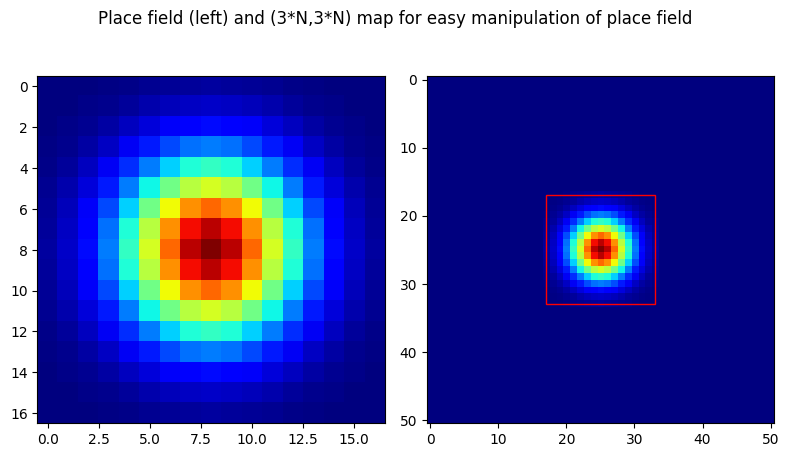

In [3]:
def make_single_field(N=16, stdev=10, shift_row=0, shift_col=0, custom_gauss=None):
    """
    N is kernel size
    """
    if custom_gauss is None:
        k1d = signal.gaussian(N, std=stdev).reshape(N, 1)
        kernel = np.outer(k1d, k1d)
    else:
        kernel = custom_gauss
    single_field = np.zeros((N*3, N*3))
    single_field[N+ceil(N/2)+shift_row, N+ceil(N/2)+shift_col] = 1  
    row, col = np.where(single_field == 1)
    rowend = row[0]+ceil(N/2)
    colend = col[0]+ceil(N/2)
    if colend >= len(single_field):
        colend -= len(single_field)
        colinter = N - colend
    else:
        colinter = N
    if rowend >= len(single_field):
        rowend -= len(single_field)
        rowinter = N - rowend
    else:
        rowinter = N

    # if N % 2 == 0:
    #     single_field[row[0]-ceil(N/2):row[0]+ceil(N/2), col[0]-ceil(N/2):col[0]+ceil(N/2)] = kernel[:rowinter, :colinter]
    # else:
    #     single_field[row[0]-N//2:row[0]+ceil(N/2), col[0]-N//2:col[0]+ceil(N/2)] = kernel[:rowinter, :colinter]

    single_field[row[0]-ceil(N/2):row[0]+N//2, col[0]-ceil(N/2):col[0]+N//2] = kernel
    return single_field

N = 17
stdev = 3
single_field = make_single_field(N, stdev)
k1d = signal.gaussian(N, std=stdev).reshape(N, 1)
kernel = np.outer(k1d, k1d)

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(1,2,1)
ax.imshow(kernel, cmap='jet')
ax = plt.subplot(1,2,2)
ax.imshow(single_field, cmap='jet')
rect = patches.Rectangle((N, N), N-1, N-1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
fig.tight_layout()
fig.suptitle('Place field (left) and (3*N,3*N) map for easy manipulation of place field')
plt.show()



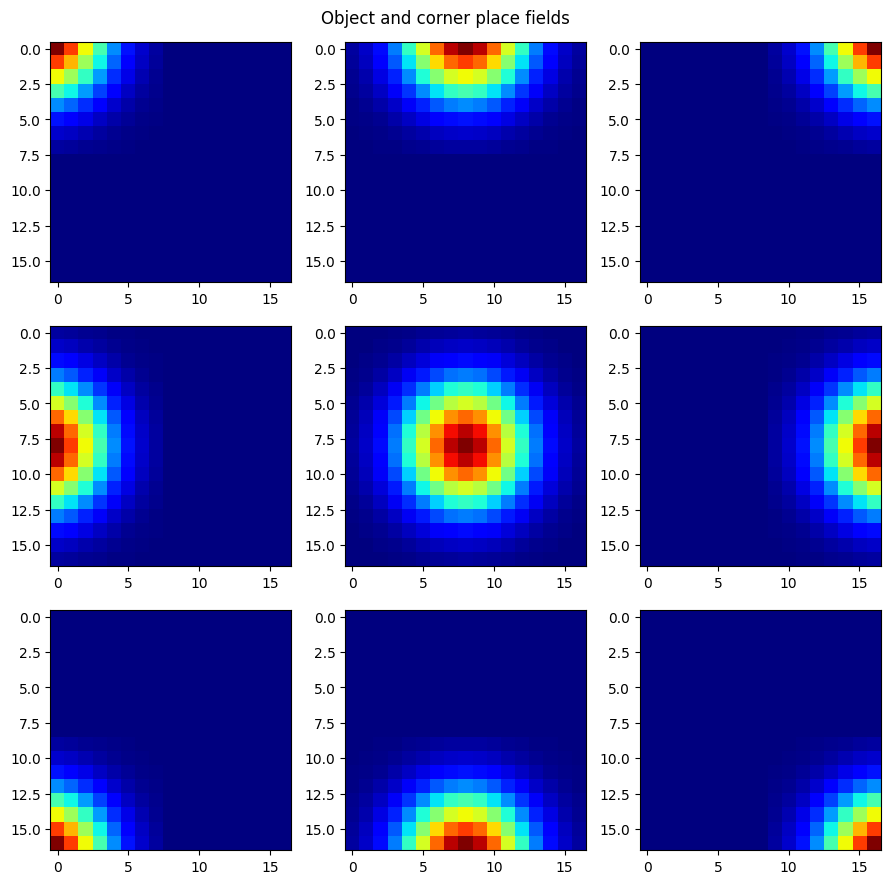

In [4]:
N = 17
stdev = 3
single_field = make_single_field(N, stdev)
top_left = make_single_field(N, stdev, shift_row=-ceil(N/2), shift_col=-ceil(N/2))
top_middle = make_single_field(N, stdev, shift_row=-ceil(N/2), shift_col=0)
top_right = make_single_field(N, stdev, shift_row=-ceil(N/2), shift_col=ceil(N/2))
right_middle = make_single_field(N, stdev, shift_row=0, shift_col=ceil(N/2))
bottom_right = make_single_field(N, stdev, shift_row=ceil(N/2), shift_col=ceil(N/2))
bottom_middle = make_single_field(N, stdev, shift_row=ceil(N/2), shift_col=0)
bottom_left = make_single_field(N, stdev, shift_row=ceil(N/2), shift_col=-ceil(N/2))
left_middle = make_single_field(N, stdev, shift_row=0, shift_col=-ceil(N/2))

to_plot = [top_left, top_middle, top_right, left_middle, single_field, right_middle, bottom_left, bottom_middle, bottom_right]

fig = plt.figure(figsize=(9,9))
axs = []
for i in range(1,10,1):
    ax = plt.subplot(3,3,i)
    ax.imshow(to_plot[i-1][N:N+N,N:N+N], cmap='jet')
    axs.append(ax)

for ax in axs:
    rect = patches.Rectangle((N, N), N, N, linewidth=1, edgecolor='k', facecolor='none')
    ax.add_patch(rect)

fig.suptitle('Object and corner place fields')
fig.tight_layout()
plt.show()

object_corner_fields = {
    'top_left': top_left[N:N+N,N:N+N],
    'top_middle': top_middle[N:N+N,N:N+N],
    'top_right': top_right[N:N+N,N:N+N],
    'right_middle': right_middle[N:N+N,N:N+N],
    'bottom_right': bottom_right[N:N+N,N:N+N],
    'bottom_middle': bottom_middle[N:N+N,N:N+N],
    'bottom_left': bottom_left[N:N+N,N:N+N],
    'left_middle': left_middle[N:N+N,N:N+N],
    'center': single_field[N:N+N,N:N+N],
}


In [5]:
def make_gauss (mesh, sxy, rxy, rot):
    x, y = mesh[0] - sxy[0], mesh[1] - sxy[1]
    px = x * np.cos(rot) - y * np.sin(rot)
    py = y * np.cos(rot) + x * np.sin(rot)
    fx = np.exp (-0.5 * (px/rxy[0])**2)
    fy = np.exp (-0.5 * (py/rxy[1])**2)
    return fx * fy

def _interpolate_matrix(matrix, new_size=(257,257), cv2_interpolation_method=cv2.INTER_CUBIC):
    '''
        Interpolate a matrix using cv2.INTER_LANCZOS4.
    '''
    return cv2.resize(matrix, dsize=new_size,
                      interpolation=cv2_interpolation_method)

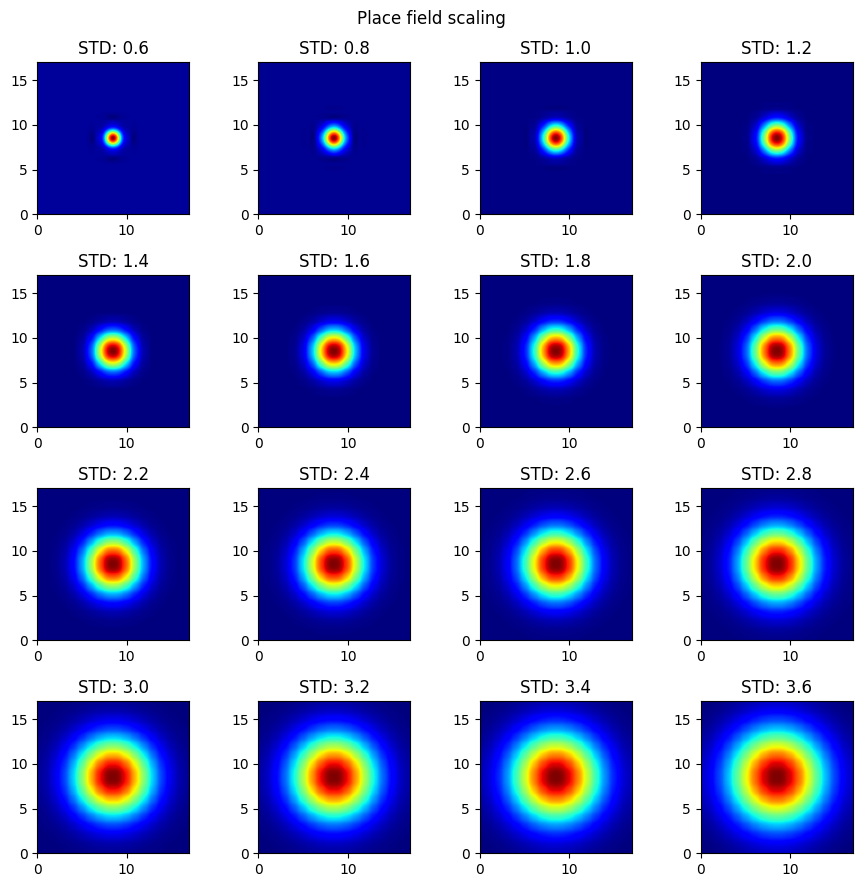

In [6]:
N = 17
# stdev = 5
fig = plt.figure(figsize=(9,9))
axs = []
scaling_fields = {}

ct = 1
for i in np.arange(0.6,4-0.2,0.2):
    # stdev+i*2
    single_field = make_single_field(N, i)

    ax = plt.subplot(4,4,ct)
    ax.imshow(_interpolate_matrix(single_field[N:N+N,N:N+N]), cmap='jet', extent=[0,N-1,0,N-1])
    ax.set_title('STD: ' + str(round(i,2)))
    axs.append(ax)
    
    scaling_fields[i] = single_field[N:N+N,N:N+N]
    ct += 1

fig.suptitle('Place field scaling')
fig.tight_layout()
plt.show()


In [7]:
from scipy.stats import multivariate_normal

N = 17
stdev = 3
px = np.arange(0,N,1)
py = np.arange(0,N,1)
mesh = np.meshgrid(px, py)

rx, ry = 1, 3
aggregate_elliptic_right_ex1 = []
step = 0.5
for i in range(12):
    sx, sy = int(N/2) + i * 0.5, int(N/2)
    rot = 90
    elliptic_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 
    aggregate_elliptic_right_ex1.append(elliptic_right_ex1)

rx, ry = 1, 3
sx, sy = int(N/2), int(N/2)
rot = 90
elliptic_left_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 

rx, ry = 2, 2
rot = 0
aggregate_circle_right_ex1 = []
step = 0.5
for i in range(12):
    sx, sy = int(N/2) + i * 0.5, int(N/2)
    circle_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 
    aggregate_circle_right_ex1.append(circle_right_ex1)

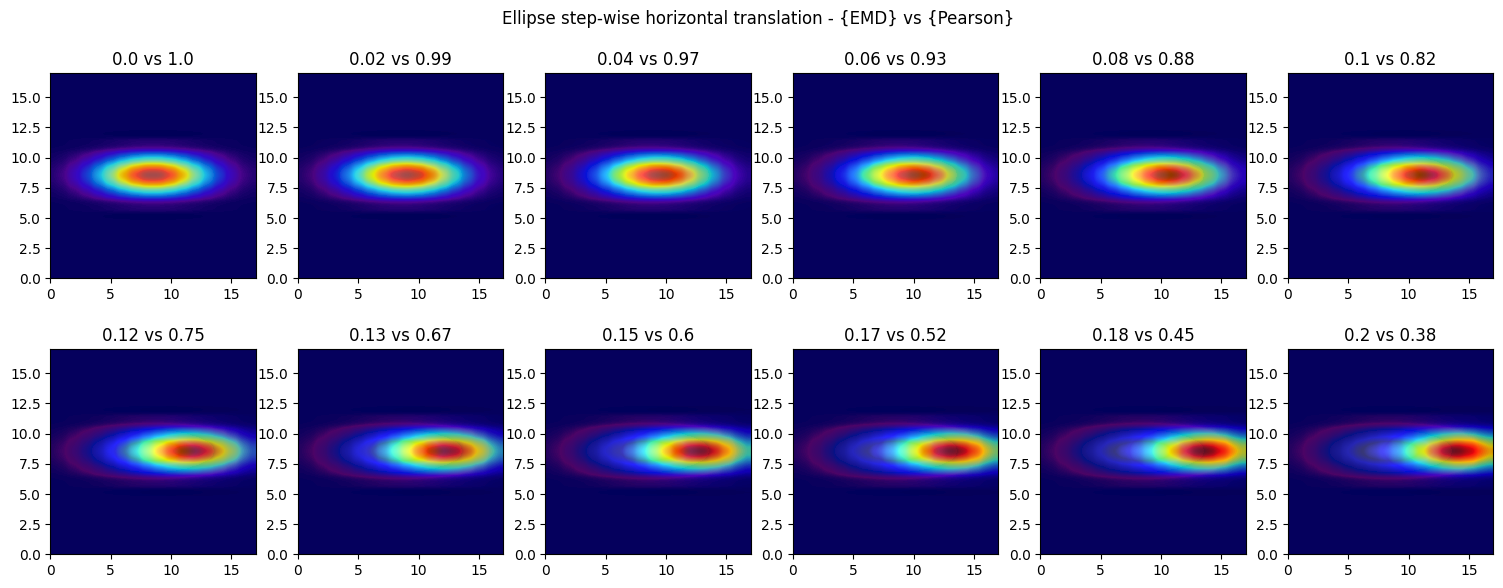

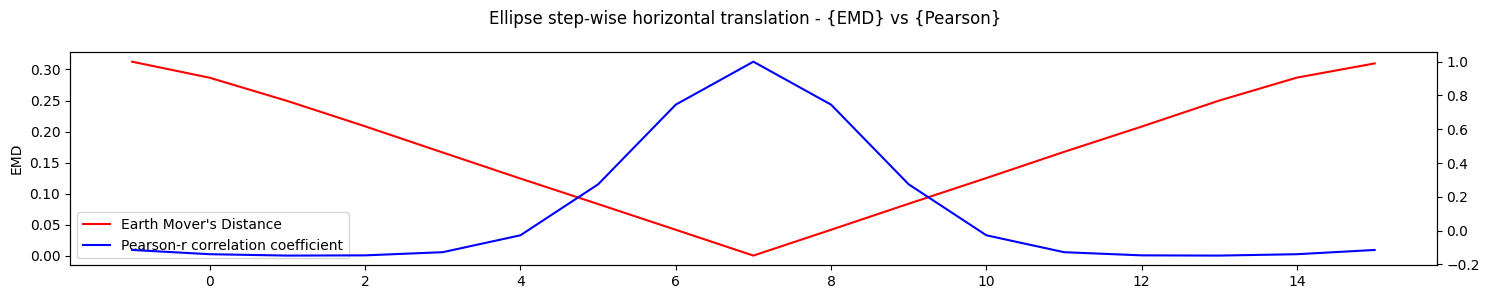

In [8]:
"""""""""""""""""""""" EXAMPLE 1 """""""""""""""""""""
""" No overlap same shape = elliptic_left_ex1 and elliptic_right_ex1 """

fig = plt.figure(figsize=(15,6))

c = 0
for elliptic_right_ex1 in aggregate_elliptic_right_ex1:

    ax = plt.subplot(2,6,c+1)
    ax.imshow(_interpolate_matrix(elliptic_right_ex1), cmap='jet', extent=[0,N-1,0,N-1])
    ax.imshow(_interpolate_matrix(elliptic_left_ex1), cmap='gist_stern', alpha=0.3, extent=[0,N-1,0,N-1])
    # ax.scatter([128], [128], color='k')

    y, x = elliptic_left_ex1.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: elliptic_left_ex1[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: elliptic_right_ex1[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    # emd = pot.wass
    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())

    ax.set_title(str(round(emd, 2)) + ' vs ' + str(round(r, 2)))

    c += 1

fig.suptitle('Ellipse step-wise horizontal translation - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,3))
emds = []
pearsons = []
rx, ry = 1, 3
rot = 90
ctr_col = []

for i in np.arange(-int(N/2),ceil(N/2),1):
    # fld = make_single_field(N, stdev, shift_row=-ceil(N/2)+i, shift_col=0 ,custom_gauss=aggregate_elliptic_right_ex1[0])
    # fld = fld[N:N+N,N:N+N]

    sx, sy = int(N/2), int(N/2) + i
    elliptic_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 


    y, x = elliptic_left_ex1.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: elliptic_left_ex1[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: elliptic_right_ex1[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())
    
    ctr_col.append(int(N/2) + i - 1)
    emds.append(emd)
    pearsons.append(r)

ax  = plt.subplot(1,1,1)
ln1 = ax.plot(ctr_col, emds,label="Earth Mover's Distance",color='r')
ax.set_ylabel('EMD')
axt = ax.twinx()
ln2 = axt.plot(ctr_col, pearsons, label='Pearson-r correlation coefficient',color='b')
axt.set_xlabel('Pearson-r')
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
fig.suptitle('Ellipse step-wise horizontal translation - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()


In [9]:


"""""""""""""""""""""" EXAMPLE 1 - POPULATION FIGURES """""""""""""""""""""
""" No overlap same shape = elliptic_left_ex1 and elliptic_right_ex1 """

y, x = elliptic_left_ex1.shape
height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
source_weights = np.array(list(map(lambda x: elliptic_left_ex1[x[0],x[1]], buckets)))
source_weights = source_weights / np.sum(source_weights)
coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
pop_shifted_emd = np.zeros(elliptic_left_ex1.shape)
pop_shifted_pearson = np.zeros(elliptic_left_ex1.shape)


rx, ry = 1, 3

def _sub1(i, j):
    sx, sy = i, j
    rot = 90
    elliptic_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 

    target_weights = np.array(list(map(lambda y: elliptic_right_ex1[y[0],y[1]], buckets)))
    target_weights = target_weights / np.sum(target_weights)
            
    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)

    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())

    return emd, r

def _sub2(i):
    emd_and_r = np.array(list(map(lambda x: _sub1(i, x), np.arange(0,len(pop_shifted_emd)))))
    return emd_and_r[:,0], emd_and_r[:,1]

combined = np.array(list(map(lambda x: _sub2(x), np.arange(0,len(pop_shifted_emd)))))
pop_shifted_emd, pop_shifted_pearson = combined[:,0,:], combined[:,1,:]


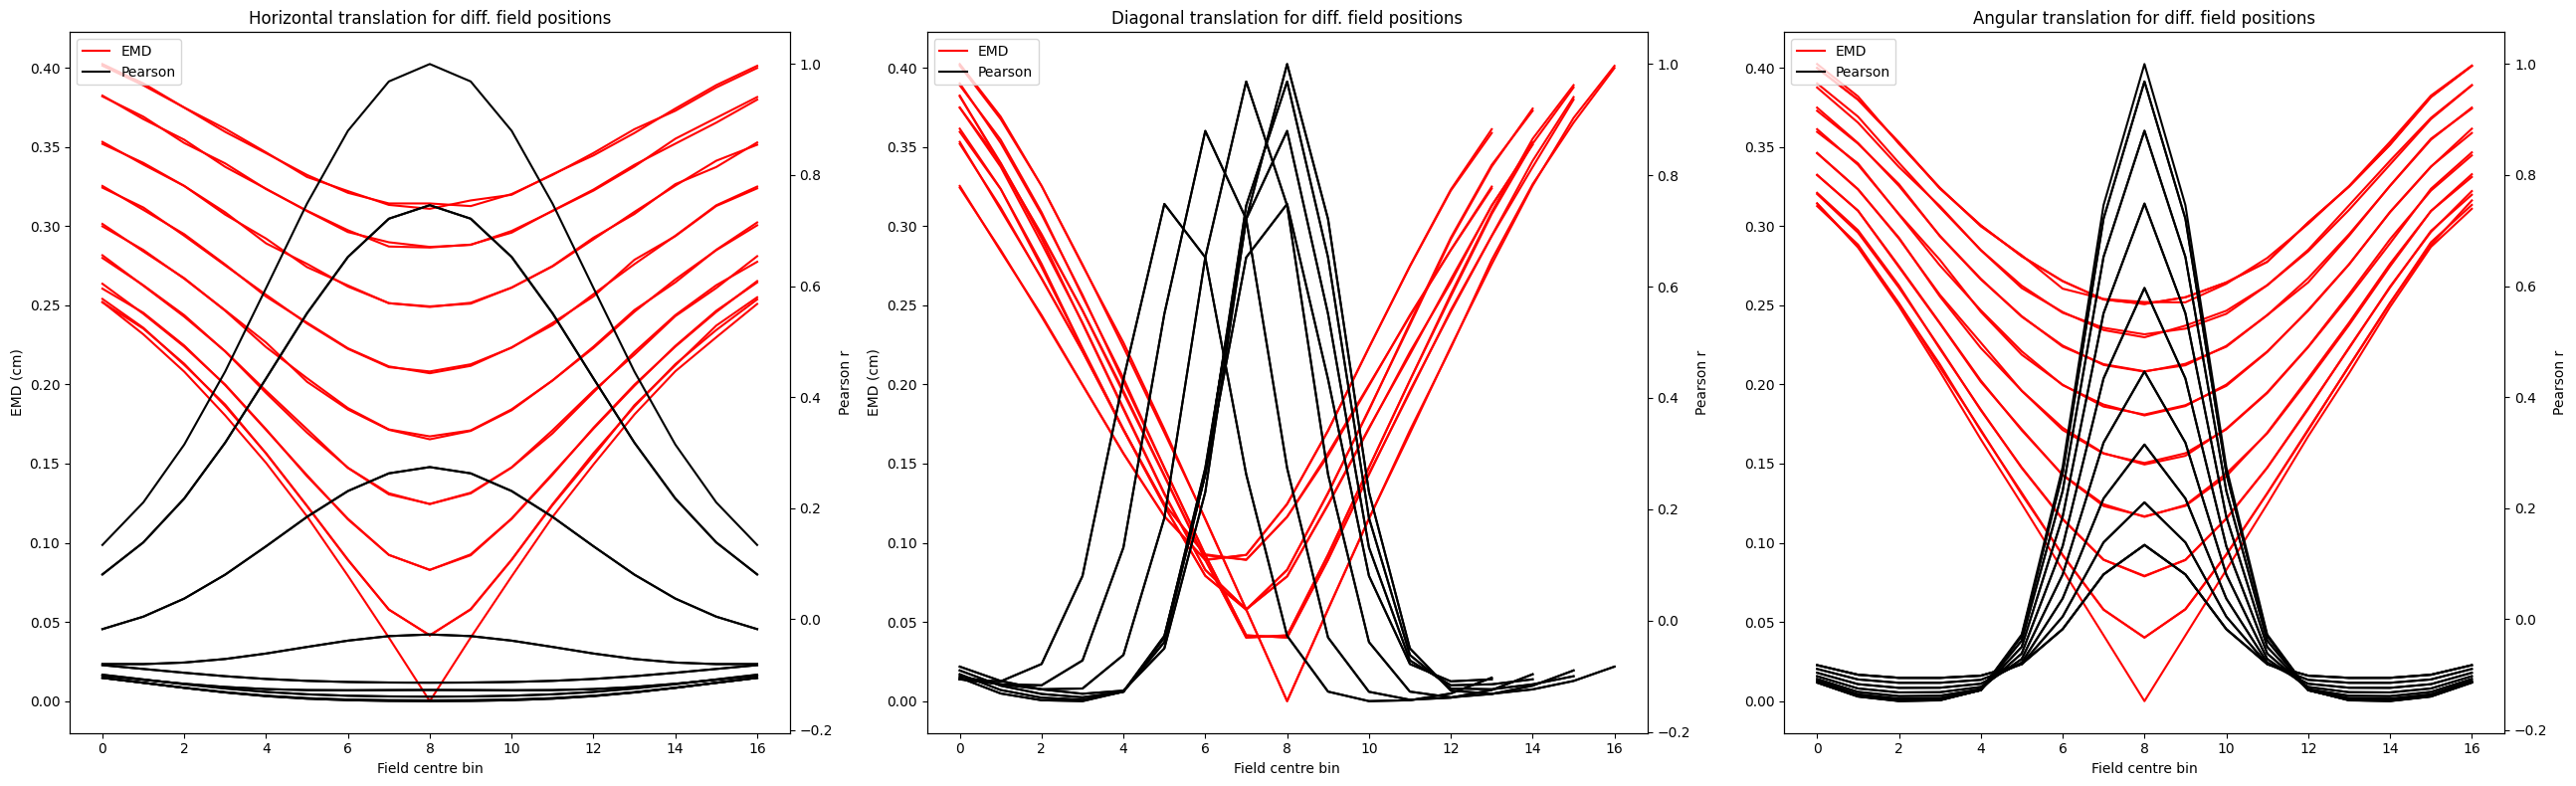

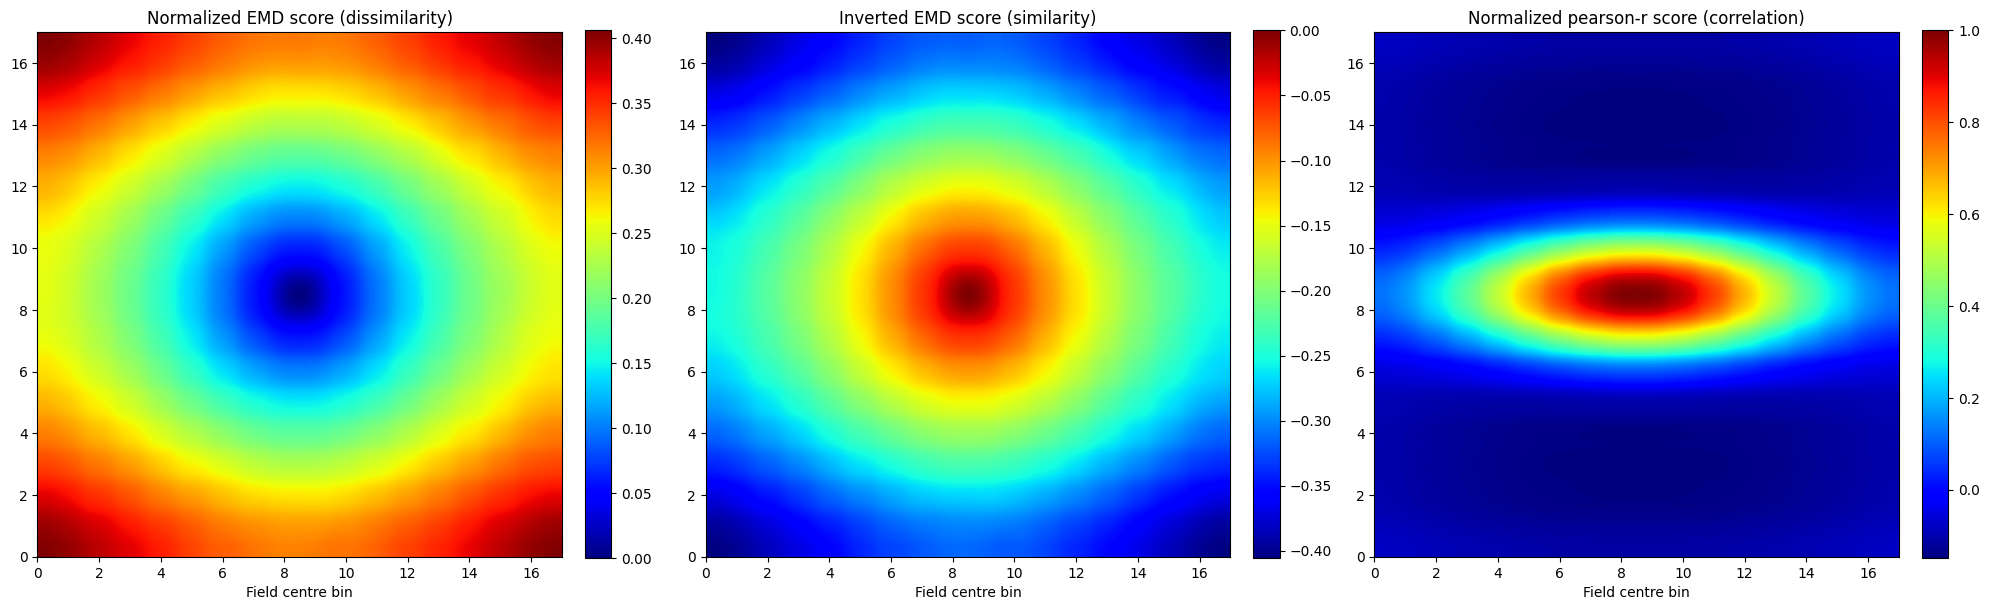

In [10]:
fig, _ = plt.subplots(1, 3, figsize=(26, 8))
ax1 = plt.subplot(1,3,1)
for i in range(N):
    p1 = ax1.plot(pop_shifted_emd[i],color='r',label='EMD')
ax1.set_xlabel('Field centre bin')
ax1.set_ylabel('EMD (cm)')
axtwin = ax1.twinx()
axtwin.set_ylabel('Pearson r')
for i in range(N):
    ptwin = axtwin.plot(pop_shifted_pearson[i],color='k',label='Pearson')
lns = p1+ptwin
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')
# ax1.set_aspect('equal')
ax1.set_title('Horizontal translation for diff. field positions')

def diag_matrix(matrix):
    diags = [matrix[::-1,:].diagonal(i) for i in range(-3,4)]
    diags.extend(matrix.diagonal(i) for i in range(3,-4,-1))
    return [n.tolist() for n in diags]

ax2 = plt.subplot(1,3,2)

diag_emd = diag_matrix(pop_shifted_emd)
for i in range(len(diag_emd)):
    p2 = ax2.plot(diag_emd[i],color='r',label='EMD')
ax2.set_xlabel('Field centre bin')
ax2.set_ylabel('EMD (cm)')
axtwin2 = ax2.twinx()
axtwin2.set_ylabel('Pearson r')

diag_pearson = diag_matrix(pop_shifted_pearson)
for i in range(len(diag_pearson)):
    ptwin2 = axtwin2.plot(diag_pearson[i],color='k',label='Pearson')
lns = p2+ptwin2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper left')
ax2.set_title('Diagonal translation for diff. field positions')

ax3 = plt.subplot(1,3,3)
rotated_emd = np.array(list(map(lambda x: ndimage.rotate(pop_shifted_emd, x, reshape=False, mode='constant', cval=np.nan), np.arange(90,91,1))))
pdct_emd = list(itertools.product(np.arange(len(rotated_emd)), np.arange(len(rotated_emd[0]))))
list(map(lambda x: ax3.plot(rotated_emd[x[0],x[1]],color='r',label='EMD'), pdct_emd))
p3 = ax3.plot(rotated_emd[0,0],color='r',label='EMD')
axtwin3 = ax3.twinx()
axtwin3.set_ylabel('Pearson r')
rotated_pearson = np.array(list(map(lambda x: ndimage.rotate(pop_shifted_pearson, x, reshape=False, mode='constant', cval=np.nan), np.arange(90,91,1))))
pdct_pearson = list(itertools.product(np.arange(len(rotated_pearson)), np.arange(len(rotated_pearson[0]))))
list(map(lambda x: axtwin3.plot(rotated_pearson[x[0],x[1]],color='k',label='EMD'), pdct_pearson))
ptwin3 = axtwin3.plot(rotated_pearson[0,0],color='k',label='Pearson')
lns = p3+ptwin3
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc='upper left')
ax3.set_title('Angular translation for diff. field positions')
ax3.set_xlabel('Field centre bin')


fig.tight_layout()
plt.show()

fig, _ = plt.subplots(1, 2, figsize=(20, 8))

ax4 = plt.subplot(1,3,1)
im = ax4.imshow(_interpolate_matrix(pop_shifted_emd), cmap='jet', extent=[0,N-1,0,N-1])
ax4.set_title('EMD score (dissimilarity)')
ax4.set_xlabel('Field centre bin')
fig.colorbar(im, ax=ax4,fraction=0.046, pad=0.04)

ax5 = plt.subplot(1,3,2)
im = ax5.imshow(_interpolate_matrix(-pop_shifted_emd), cmap='jet', extent=[0,N-1,0,N-1])
ax5.set_title('Inverted EMD score (similarity)')
ax5.set_xlabel('Field centre bin')
fig.colorbar(im, ax=ax5,fraction=0.046, pad=0.04)

ax6 = plt.subplot(1,3,3)
ax6.set_xlabel('Field centre bin')
im = ax6.imshow(_interpolate_matrix(pop_shifted_pearson), cmap='jet', extent=[0,N-1,0,N-1])
ax6.set_title('Pearson-r score (correlation)')
fig.colorbar(im, ax=ax6,fraction=0.046, pad=0.04)

fig.tight_layout()
plt.show()

In [50]:
from scipy.stats import multivariate_normal

N = 17
stdev = 3
px = np.arange(0,N,1)
py = np.arange(0,N,1)
mesh = np.meshgrid(px, py)

rx, ry = 1, 3
aggregate_elliptic_right_ex1 = []
step = 0.5
for i in range(12):
    sx, sy = int(N/2) + i * 0.5, int(N/2)
    rot = 90
    elliptic_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 
    aggregate_elliptic_right_ex1.append(elliptic_right_ex1)

rx, ry = 1, 3
sx, sy = int(N/2), int(N/2)
rot = 0
elliptic_left_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 

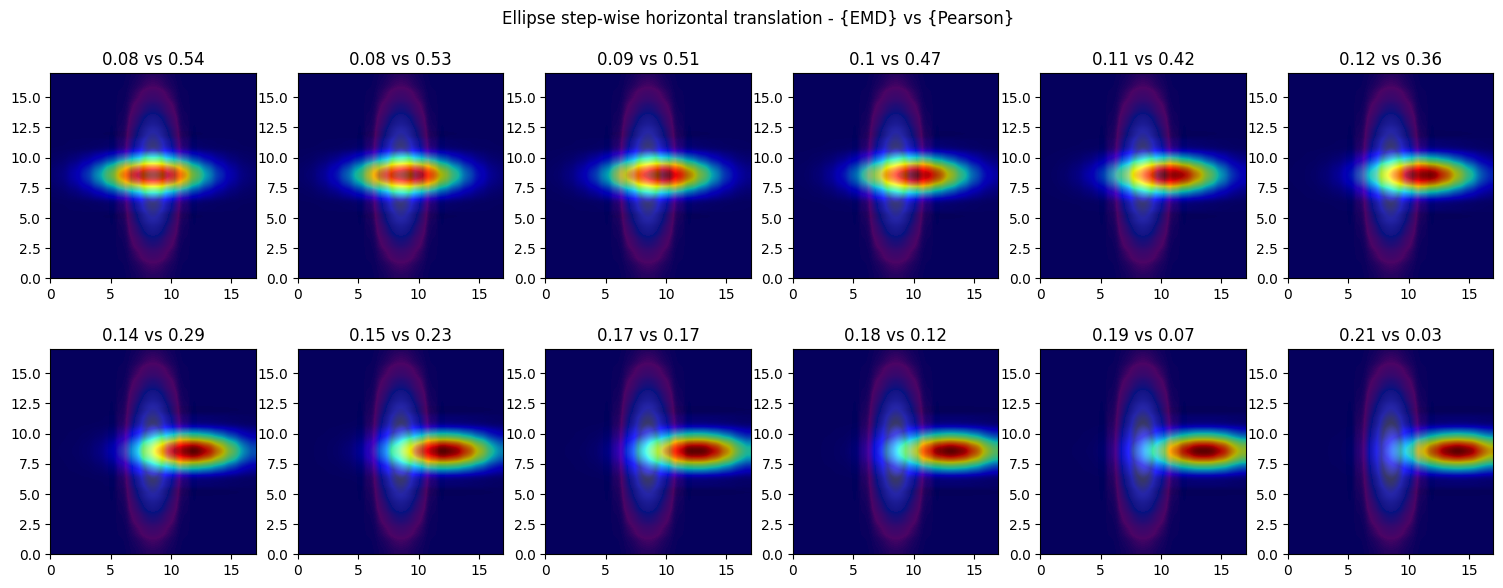

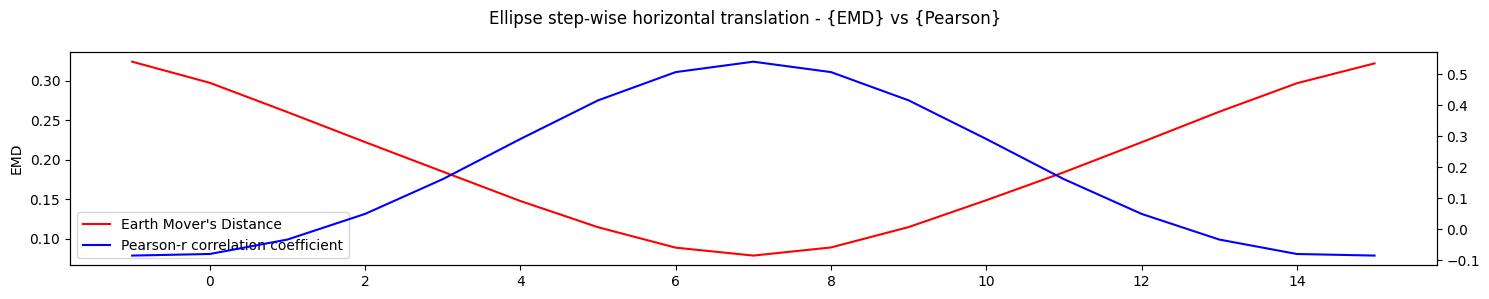

In [51]:
"""""""""""""""""""""" EXAMPLE 1 """""""""""""""""""""
""" No overlap same shape = elliptic_left_ex1 and elliptic_right_ex1 """

fig = plt.figure(figsize=(15,6))

c = 0
for elliptic_right_ex1 in aggregate_elliptic_right_ex1:

    ax = plt.subplot(2,6,c+1)
    ax.imshow(_interpolate_matrix(elliptic_right_ex1), cmap='jet', extent=[0,N-1,0,N-1])
    ax.imshow(_interpolate_matrix(elliptic_left_ex1), cmap='gist_stern', alpha=0.3, extent=[0,N-1,0,N-1])
    # ax.scatter([128], [128], color='k')

    y, x = elliptic_left_ex1.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: elliptic_left_ex1[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: elliptic_right_ex1[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    # emd = pot.wass
    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())

    ax.set_title(str(round(emd, 2)) + ' vs ' + str(round(r, 2)))

    c += 1

fig.suptitle('Ellipse step-wise horizontal translation - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,3))
emds = []
pearsons = []
rx, ry = 1, 3
rot = 90
ctr_col = []

for i in np.arange(-int(N/2),ceil(N/2),1):
    # fld = make_single_field(N, stdev, shift_row=-ceil(N/2)+i, shift_col=0 ,custom_gauss=aggregate_elliptic_right_ex1[0])
    # fld = fld[N:N+N,N:N+N]

    sx, sy = int(N/2), int(N/2) + i
    elliptic_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 


    y, x = elliptic_left_ex1.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: elliptic_left_ex1[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: elliptic_right_ex1[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())
    
    ctr_col.append(int(N/2) + i - 1)
    emds.append(emd)
    pearsons.append(r)

ax  = plt.subplot(1,1,1)
ln1 = ax.plot(ctr_col, emds,label="Earth Mover's Distance",color='r')
ax.set_ylabel('EMD')
axt = ax.twinx()
ln2 = axt.plot(ctr_col, pearsons, label='Pearson-r correlation coefficient',color='b')
axt.set_xlabel('Pearson-r')
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
fig.suptitle('Ellipse step-wise horizontal translation - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()


In [52]:


"""""""""""""""""""""" EXAMPLE 1 - POPULATION FIGURES """""""""""""""""""""
""" No overlap same shape = elliptic_left_ex1 and elliptic_right_ex1 """

y, x = elliptic_left_ex1.shape
height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
source_weights = np.array(list(map(lambda x: elliptic_left_ex1[x[0],x[1]], buckets)))
source_weights = source_weights / np.sum(source_weights)
coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
pop_shifted_emd = np.zeros(elliptic_left_ex1.shape)
pop_shifted_pearson = np.zeros(elliptic_left_ex1.shape)


rx, ry = 1, 3

def _sub1(i, j):
    sx, sy = i, j
    rot = 90
    elliptic_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 

    target_weights = np.array(list(map(lambda y: elliptic_right_ex1[y[0],y[1]], buckets)))
    target_weights = target_weights / np.sum(target_weights)
            
    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)

    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())

    return emd, r

def _sub2(i):
    emd_and_r = np.array(list(map(lambda x: _sub1(i, x), np.arange(0,len(pop_shifted_emd)))))
    return emd_and_r[:,0], emd_and_r[:,1]

combined = np.array(list(map(lambda x: _sub2(x), np.arange(0,len(pop_shifted_emd)))))
pop_shifted_emd, pop_shifted_pearson = combined[:,0,:], combined[:,1,:]


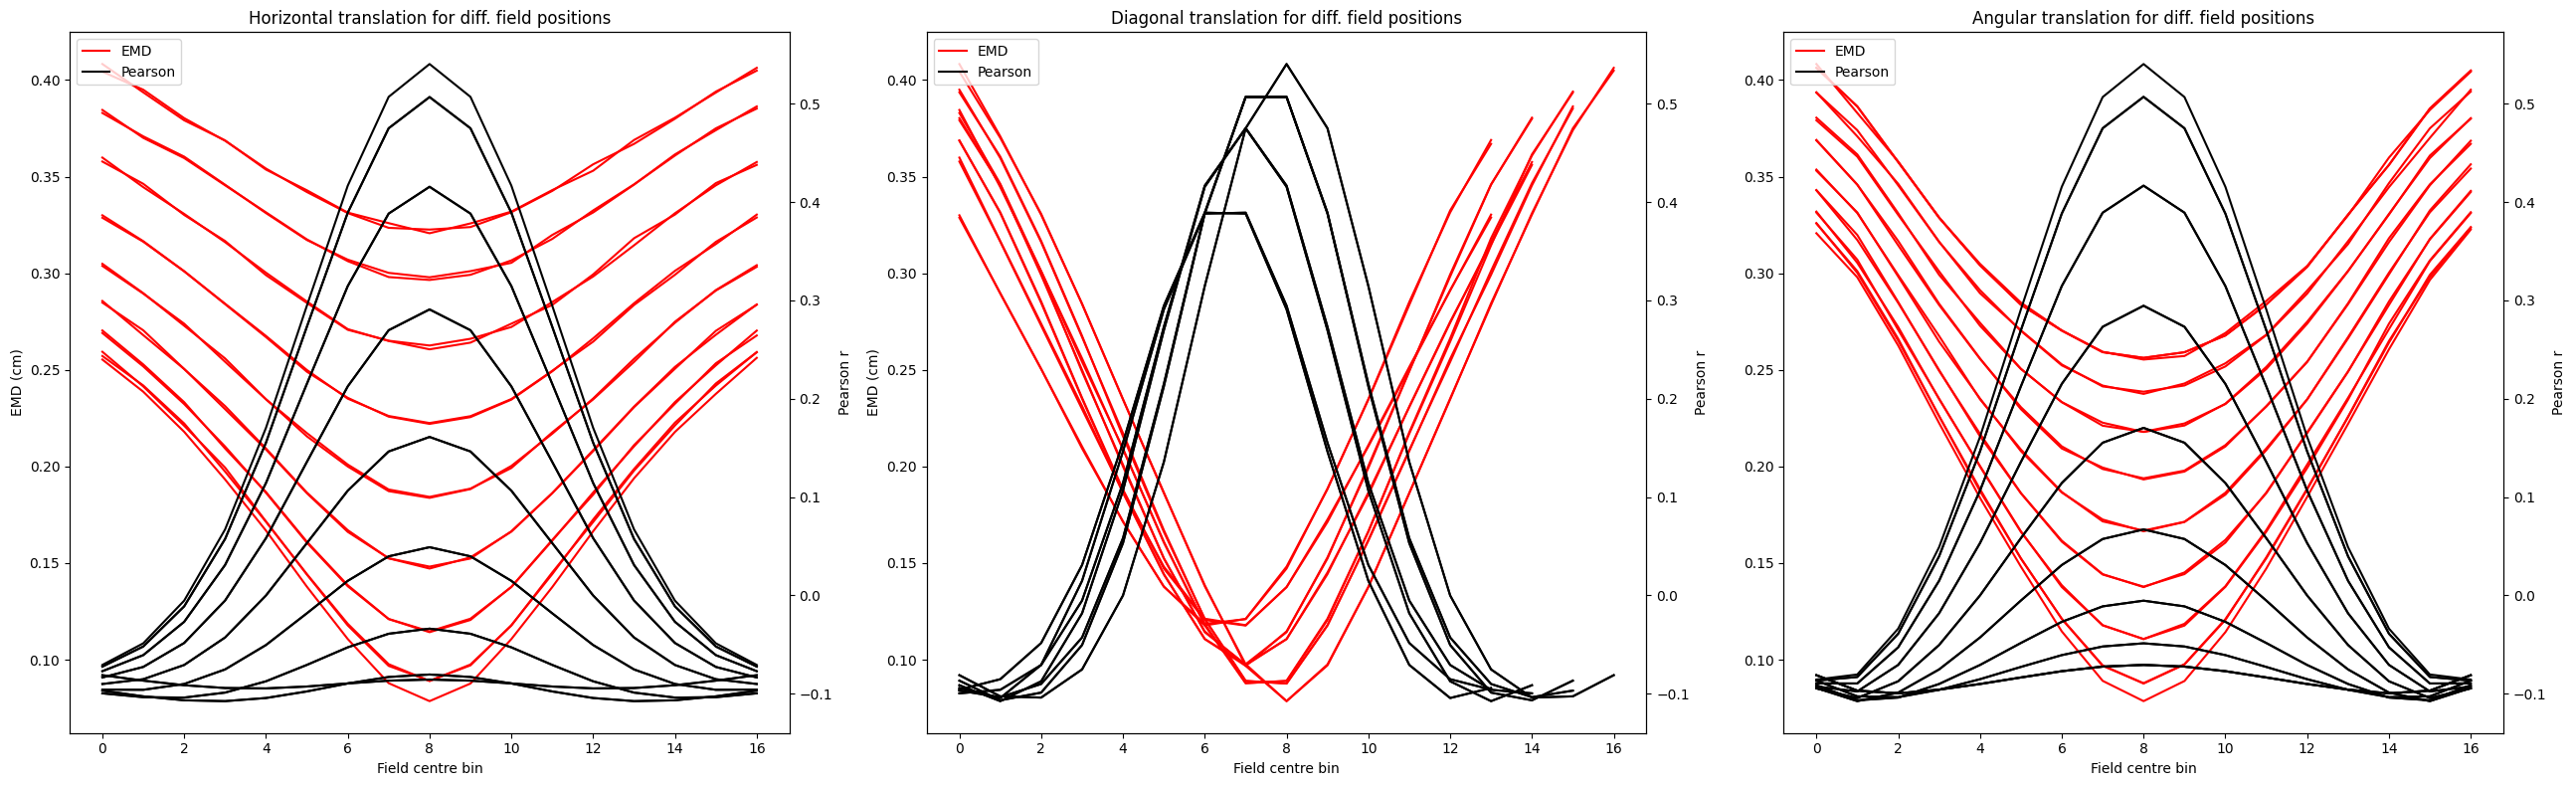

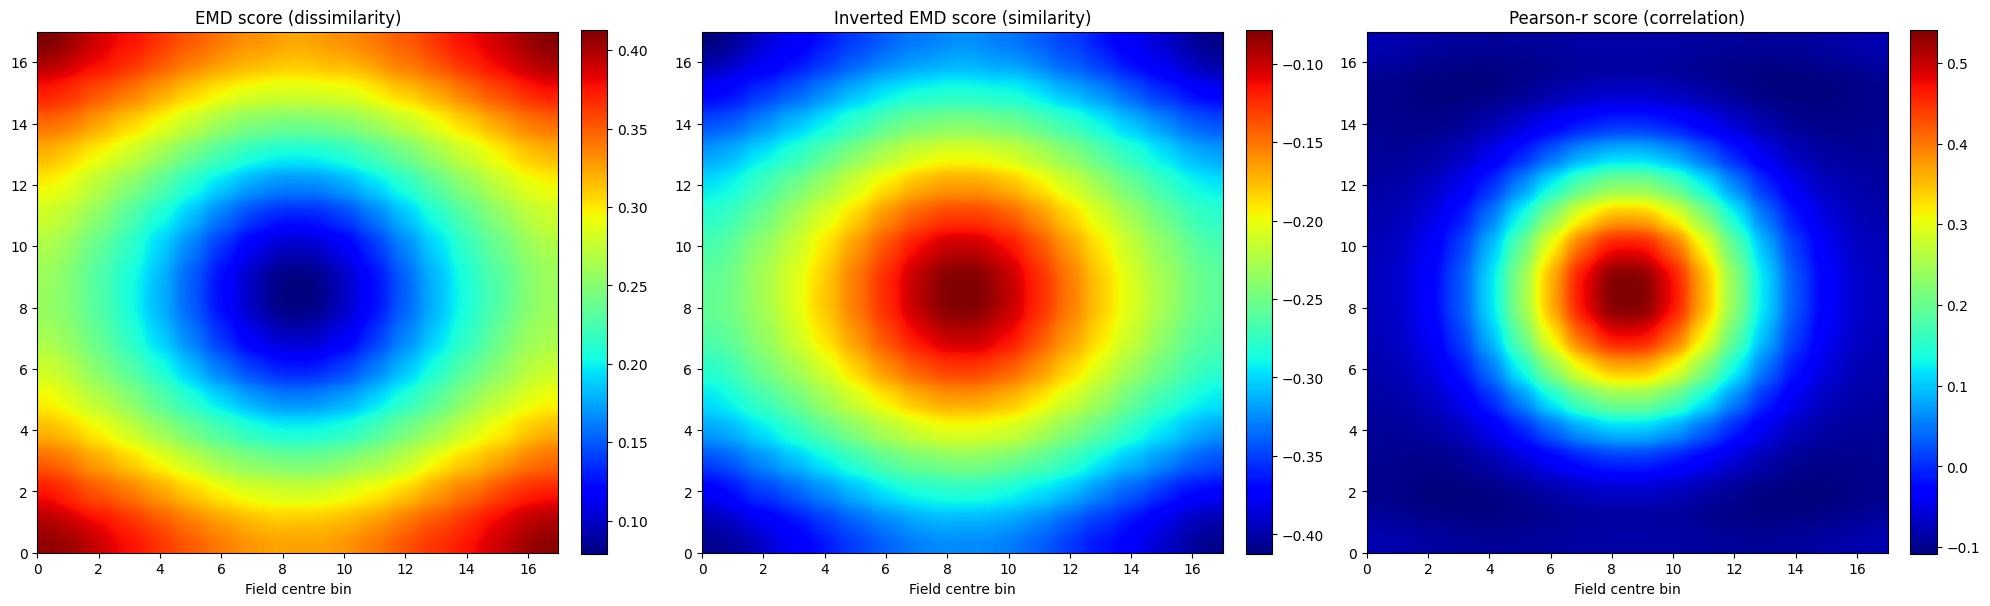

In [53]:
fig, _ = plt.subplots(1, 3, figsize=(26, 8))
ax1 = plt.subplot(1,3,1)
for i in range(N):
    p1 = ax1.plot(pop_shifted_emd[i],color='r',label='EMD')
ax1.set_xlabel('Field centre bin')
ax1.set_ylabel('EMD (cm)')
axtwin = ax1.twinx()
axtwin.set_ylabel('Pearson r')
for i in range(N):
    ptwin = axtwin.plot(pop_shifted_pearson[i],color='k',label='Pearson')
lns = p1+ptwin
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')
# ax1.set_aspect('equal')
ax1.set_title('Horizontal translation for diff. field positions')

def diag_matrix(matrix):
    diags = [matrix[::-1,:].diagonal(i) for i in range(-3,4)]
    diags.extend(matrix.diagonal(i) for i in range(3,-4,-1))
    return [n.tolist() for n in diags]

ax2 = plt.subplot(1,3,2)

diag_emd = diag_matrix(pop_shifted_emd)
for i in range(len(diag_emd)):
    p2 = ax2.plot(diag_emd[i],color='r',label='EMD')
ax2.set_xlabel('Field centre bin')
ax2.set_ylabel('EMD (cm)')
axtwin2 = ax2.twinx()
axtwin2.set_ylabel('Pearson r')

diag_pearson = diag_matrix(pop_shifted_pearson)
for i in range(len(diag_pearson)):
    ptwin2 = axtwin2.plot(diag_pearson[i],color='k',label='Pearson')
lns = p2+ptwin2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper left')
ax2.set_title('Diagonal translation for diff. field positions')

ax3 = plt.subplot(1,3,3)
rotated_emd = np.array(list(map(lambda x: ndimage.rotate(pop_shifted_emd, x, reshape=False, mode='constant', cval=np.nan), np.arange(90,91,1))))
pdct_emd = list(itertools.product(np.arange(len(rotated_emd)), np.arange(len(rotated_emd[0]))))
list(map(lambda x: ax3.plot(rotated_emd[x[0],x[1]],color='r',label='EMD'), pdct_emd))
p3 = ax3.plot(rotated_emd[0,0],color='r',label='EMD')
axtwin3 = ax3.twinx()
axtwin3.set_ylabel('Pearson r')
rotated_pearson = np.array(list(map(lambda x: ndimage.rotate(pop_shifted_pearson, x, reshape=False, mode='constant', cval=np.nan), np.arange(90,91,1))))
pdct_pearson = list(itertools.product(np.arange(len(rotated_pearson)), np.arange(len(rotated_pearson[0]))))
list(map(lambda x: axtwin3.plot(rotated_pearson[x[0],x[1]],color='k',label='EMD'), pdct_pearson))
ptwin3 = axtwin3.plot(rotated_pearson[0,0],color='k',label='Pearson')
lns = p3+ptwin3
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc='upper left')
ax3.set_title('Angular translation for diff. field positions')
ax3.set_xlabel('Field centre bin')


fig.tight_layout()
plt.show()

fig, _ = plt.subplots(1, 2, figsize=(20, 8))

ax4 = plt.subplot(1,3,1)
im = ax4.imshow(_interpolate_matrix(pop_shifted_emd), cmap='jet', extent=[0,N-1,0,N-1])
ax4.set_title('EMD score (dissimilarity)')
ax4.set_xlabel('Field centre bin')
fig.colorbar(im, ax=ax4,fraction=0.046, pad=0.04)

ax5 = plt.subplot(1,3,2)
im = ax5.imshow(_interpolate_matrix(-pop_shifted_emd), cmap='jet', extent=[0,N-1,0,N-1])
ax5.set_title('Inverted EMD score (similarity)')
ax5.set_xlabel('Field centre bin')
fig.colorbar(im, ax=ax5,fraction=0.046, pad=0.04)

ax6 = plt.subplot(1,3,3)
ax6.set_xlabel('Field centre bin')
im = ax6.imshow(_interpolate_matrix(pop_shifted_pearson), cmap='jet', extent=[0,N-1,0,N-1])
ax6.set_title('Pearson-r score (correlation)')
fig.colorbar(im, ax=ax6,fraction=0.046, pad=0.04)

fig.tight_layout()
plt.show()

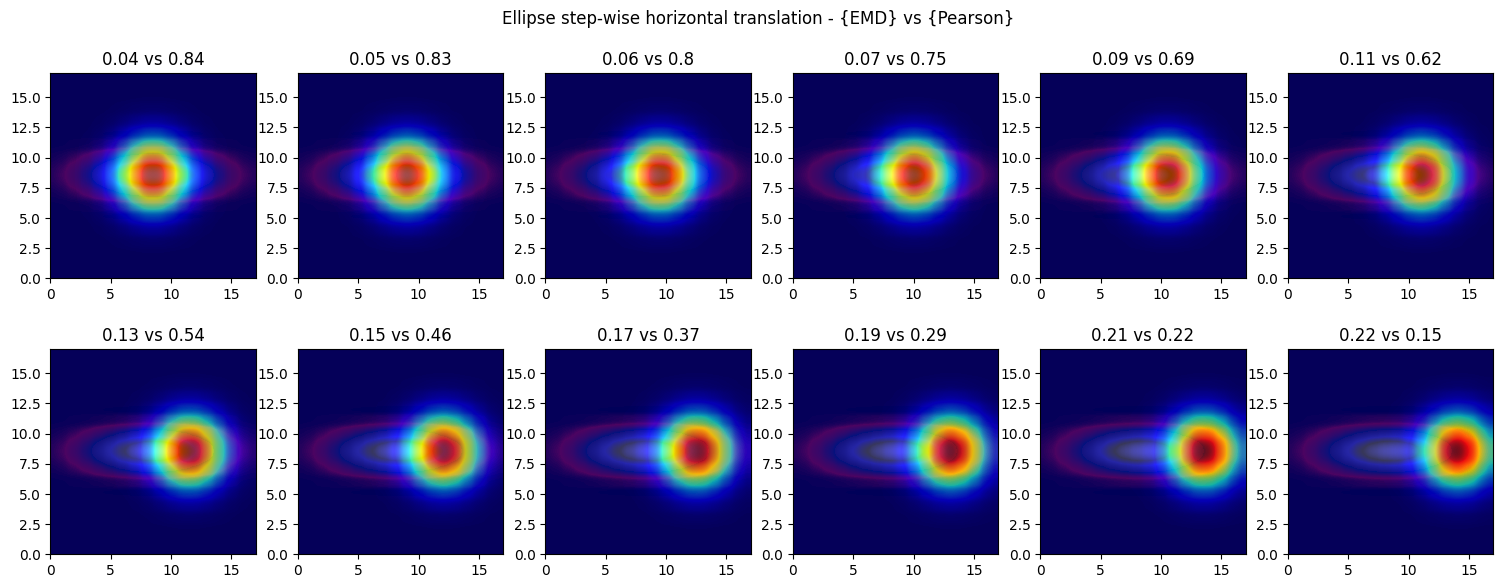

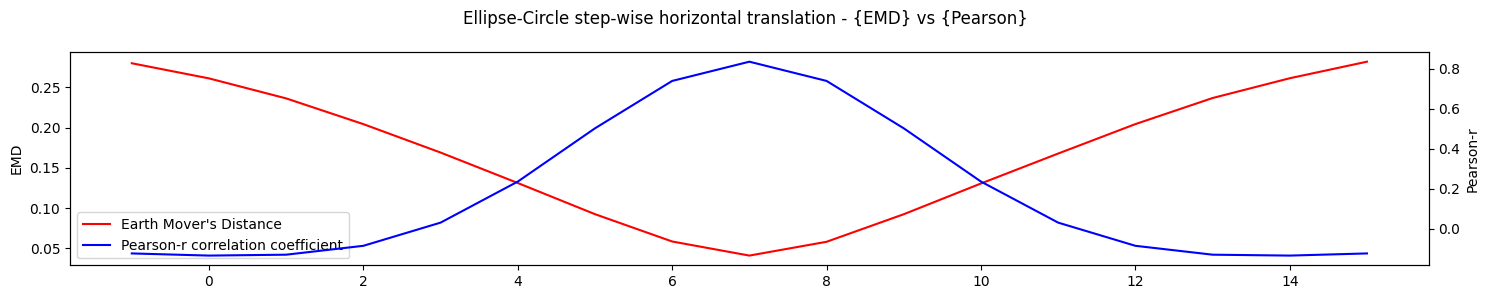

In [11]:
"""""""""""""""""""""" EXAMPLE 1 """""""""""""""""""""
""" No overlap diff shape = elliptic_left_ex1 and circle_right_ex1 """

fig = plt.figure(figsize=(15,6))

c = 0
for circle_right_ex1 in aggregate_circle_right_ex1:

    ax = plt.subplot(2,6,c+1)
    ax.imshow(_interpolate_matrix(circle_right_ex1), cmap='jet', extent=[0,N-1,0,N-1])
    ax.imshow(_interpolate_matrix(elliptic_left_ex1), cmap='gist_stern', alpha=0.3, extent=[0,N-1,0,N-1])

    y, x = elliptic_left_ex1.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: elliptic_left_ex1[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: circle_right_ex1[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    # emd = pot.wass
    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())

    ax.set_title(str(round(emd, 2)) + ' vs ' + str(round(r, 2)))

    c += 1

fig.suptitle('Ellipse step-wise horizontal translation - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,3))
emds = []
pearsons = []
rx, ry = 2, 2
rot = 90
ctr_col = []

for i in np.arange(-int(N/2),ceil(N/2),1):
    # fld = make_single_field(N, stdev, shift_row=-ceil(N/2)+i, shift_col=0 ,custom_gauss=aggregate_elliptic_right_ex1[0])
    # fld = fld[N:N+N,N:N+N]

    sx, sy = int(N/2), int(N/2) + i
    circle_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 


    y, x = elliptic_left_ex1.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: elliptic_left_ex1[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: circle_right_ex1[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())

    ctr_col.append(int(N/2) + i - 1)
    emds.append(emd)
    pearsons.append(r)

ax  = plt.subplot(1,1,1)
ln1 = ax.plot(ctr_col, emds,label="Earth Mover's Distance",color='r')
axt = ax.twinx()
ln2 = axt.plot(ctr_col, pearsons, label='Pearson-r correlation coefficient',color='b')
ax.set_ylabel('EMD')
axt.set_ylabel('Pearson-r')
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
fig.suptitle('Ellipse-Circle step-wise horizontal translation - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()



In [12]:


"""""""""""""""""""""" EXAMPLE 1 - POPULATION FIGURES """""""""""""""""""""
""" No overlap diff shape = elliptic_left_ex1 and circle_right_ex1 """

y, x = elliptic_left_ex1.shape
height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
source_weights = np.array(list(map(lambda x: elliptic_left_ex1[x[0],x[1]], buckets)))
source_weights = source_weights / np.sum(source_weights)
coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
pop_shifted_emd = np.zeros(elliptic_left_ex1.shape)
pop_shifted_pearson = np.zeros(elliptic_left_ex1.shape)


rx, ry = 1, 1

def _sub1(i, j):
    sx, sy = i, j
    rot = 90
    circle_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 

    target_weights = np.array(list(map(lambda y: circle_right_ex1[y[0],y[1]], buckets)))
    target_weights = target_weights / np.sum(target_weights)
            
    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)

    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())

    return emd, r

def _sub2(i):
    emd_and_r = np.array(list(map(lambda x: _sub1(i, x), np.arange(0,len(pop_shifted_emd)))))
    return emd_and_r[:,0], emd_and_r[:,1]

combined = np.array(list(map(lambda x: _sub2(x), np.arange(0,len(pop_shifted_emd)))))
pop_shifted_emd, pop_shifted_pearson = combined[:,0,:], combined[:,1,:]


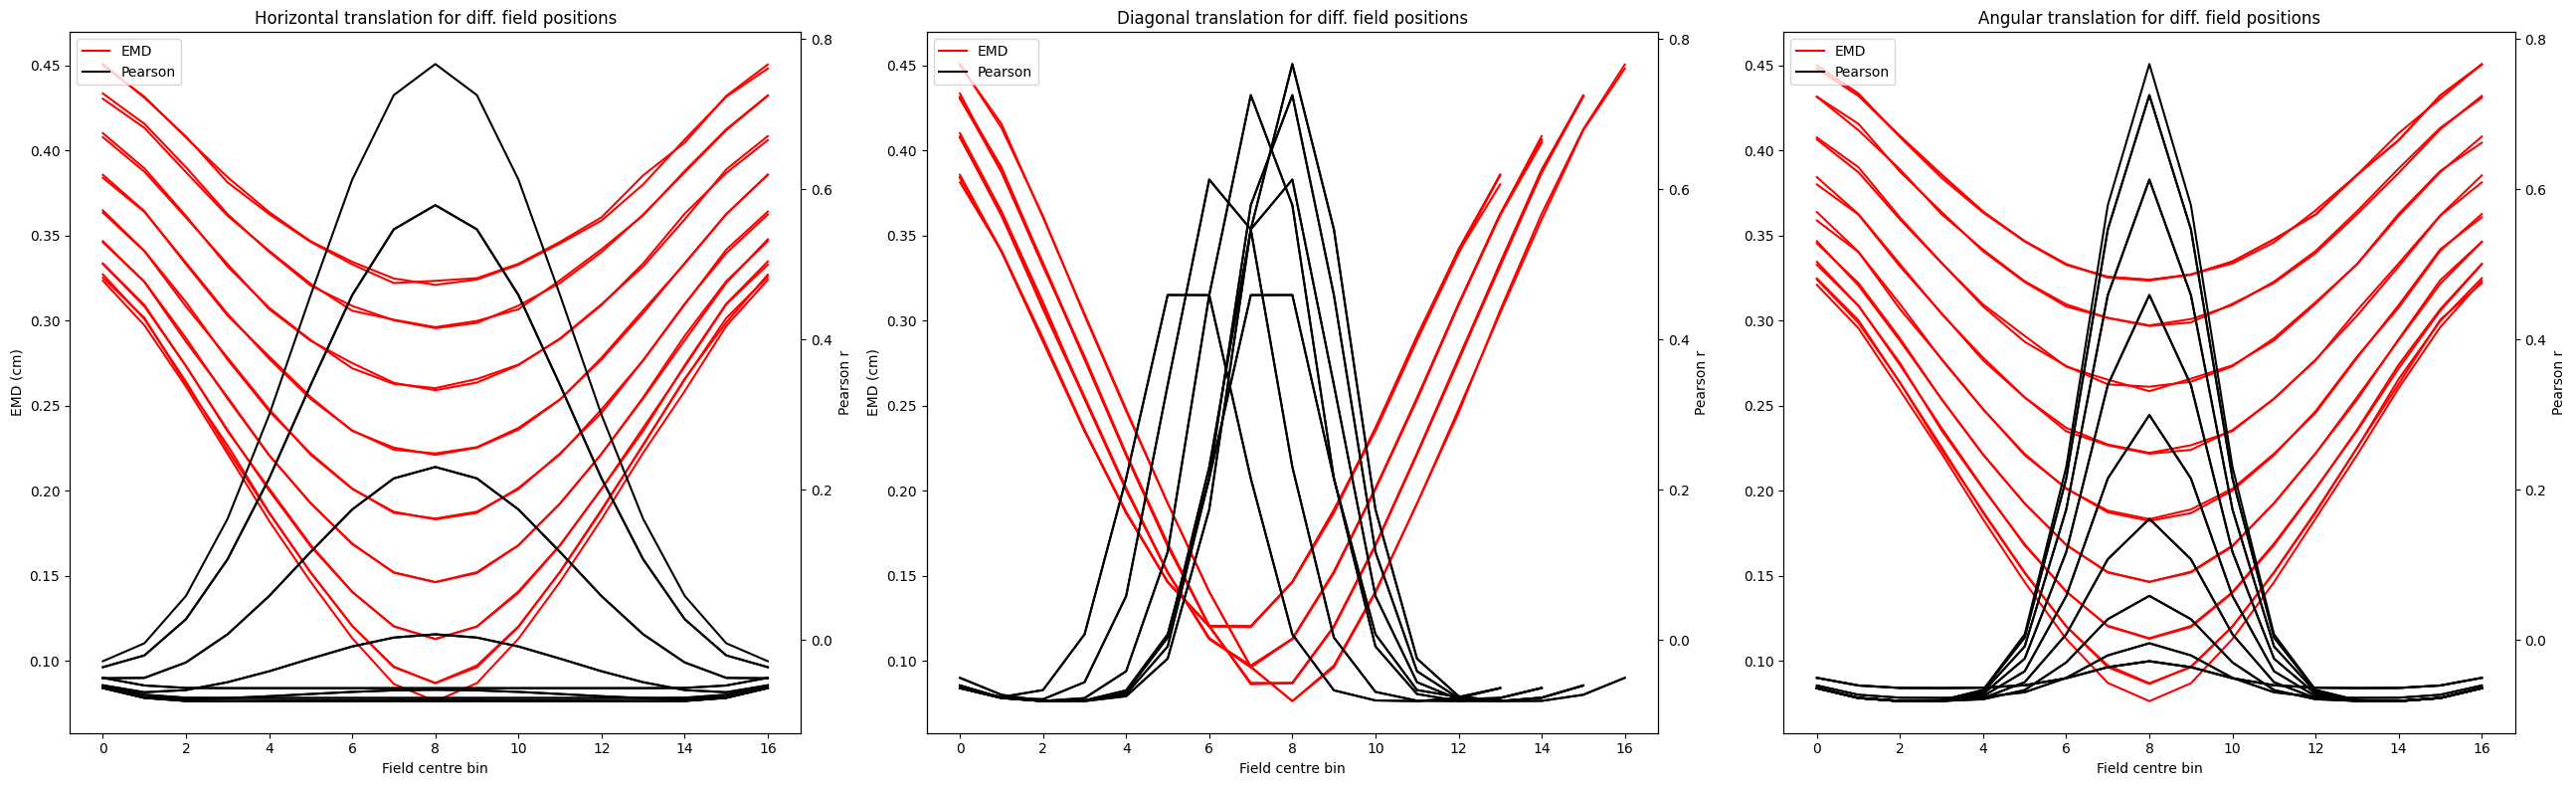

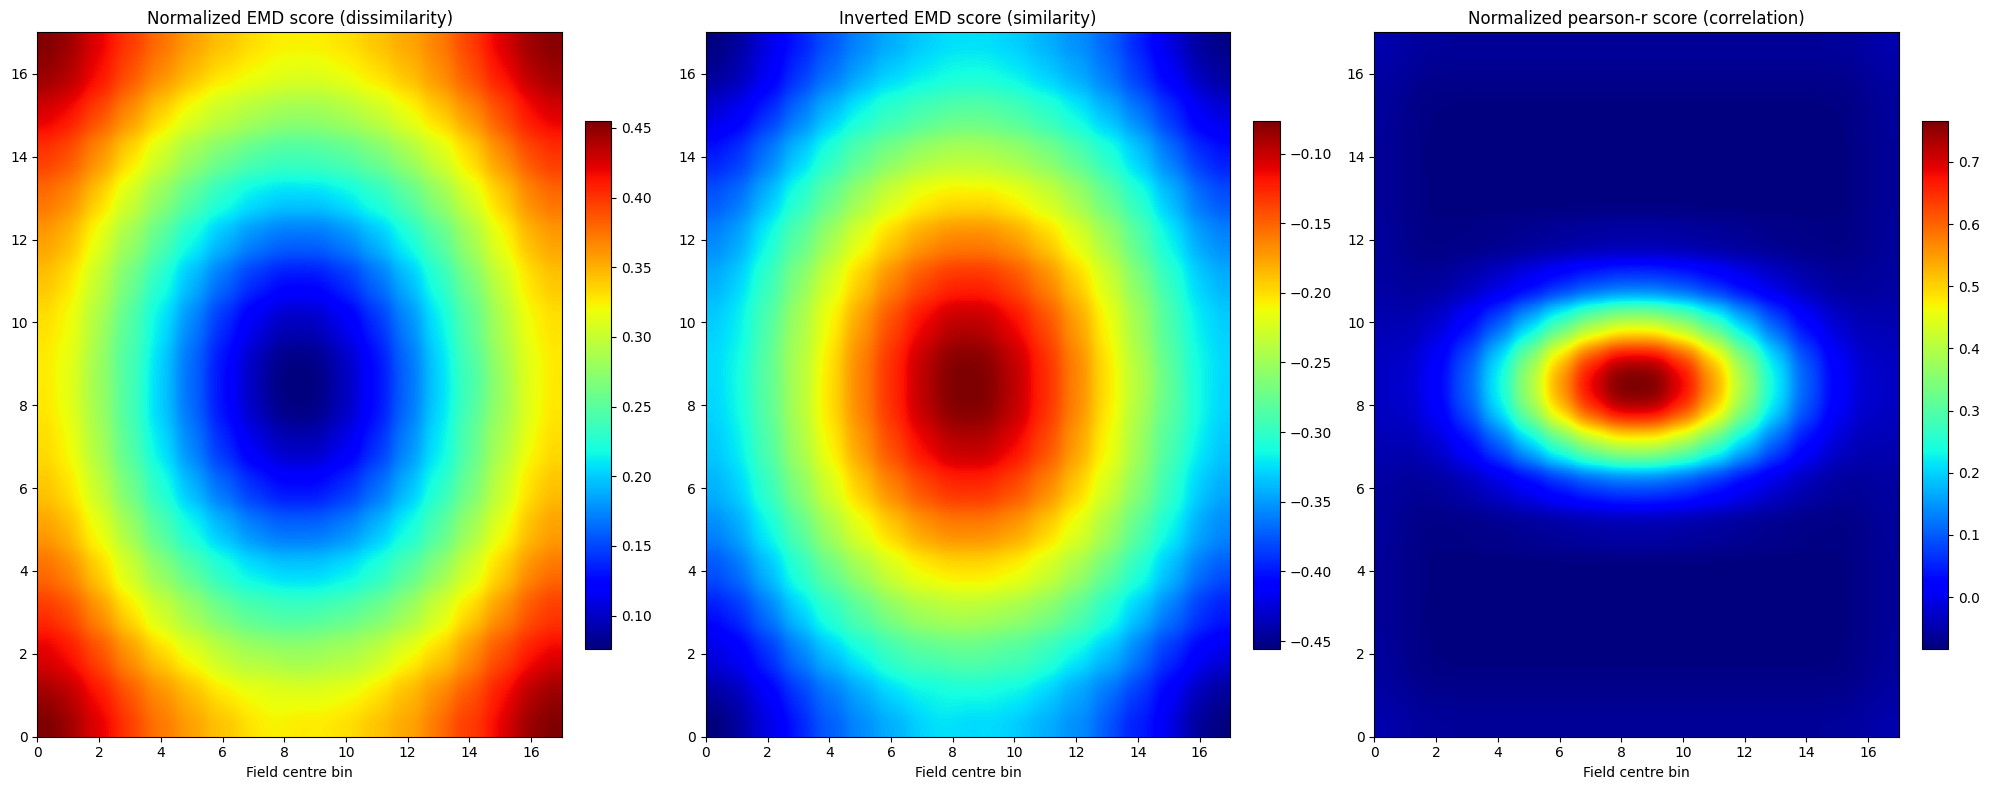

In [13]:
fig, _ = plt.subplots(1, 3, figsize=(26, 8))
ax1 = plt.subplot(1,3,1)
for i in range(N):
    p1 = ax1.plot(pop_shifted_emd[i],color='r',label='EMD')
ax1.set_xlabel('Field centre bin')
ax1.set_ylabel('EMD (cm)')
axtwin = ax1.twinx()
axtwin.set_ylabel('Pearson r')
for i in range(N):
    ptwin = axtwin.plot(pop_shifted_pearson[i],color='k',label='Pearson')
lns = p1+ptwin
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')
# ax1.set_aspect('equal')
ax1.set_title('Horizontal translation for diff. field positions')

def diag_matrix(matrix):
    diags = [matrix[::-1,:].diagonal(i) for i in range(-3,4)]
    diags.extend(matrix.diagonal(i) for i in range(3,-4,-1))
    return [n.tolist() for n in diags]

ax2 = plt.subplot(1,3,2)

diag_emd = diag_matrix(pop_shifted_emd)
for i in range(len(diag_emd)):
    p2 = ax2.plot(diag_emd[i],color='r',label='EMD')
ax2.set_xlabel('Field centre bin')
ax2.set_ylabel('EMD (cm)')
axtwin2 = ax2.twinx()
axtwin2.set_ylabel('Pearson r')

diag_pearson = diag_matrix(pop_shifted_pearson)
for i in range(len(diag_pearson)):
    ptwin2 = axtwin2.plot(diag_pearson[i],color='k',label='Pearson')
lns = p2+ptwin2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper left')
ax2.set_title('Diagonal translation for diff. field positions')

ax3 = plt.subplot(1,3,3)
rotated_emd = np.array(list(map(lambda x: ndimage.rotate(pop_shifted_emd, x, reshape=False, mode='constant', cval=np.nan), np.arange(90,91,1))))
pdct_emd = list(itertools.product(np.arange(len(rotated_emd)), np.arange(len(rotated_emd[0]))))
list(map(lambda x: ax3.plot(rotated_emd[x[0],x[1]],color='r',label='EMD'), pdct_emd))
p3 = ax3.plot(rotated_emd[0,0],color='r',label='EMD')
axtwin3 = ax3.twinx()
axtwin3.set_ylabel('Pearson r')
rotated_pearson = np.array(list(map(lambda x: ndimage.rotate(pop_shifted_pearson, x, reshape=False, mode='constant', cval=np.nan), np.arange(90,91,1))))
pdct_pearson = list(itertools.product(np.arange(len(rotated_pearson)), np.arange(len(rotated_pearson[0]))))
list(map(lambda x: axtwin3.plot(rotated_pearson[x[0],x[1]],color='k',label='EMD'), pdct_pearson))
ptwin3 = axtwin3.plot(rotated_pearson[0,0],color='k',label='Pearson')
lns = p3+ptwin3
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc='upper left')
ax3.set_title('Angular translation for diff. field positions')
ax3.set_xlabel('Field centre bin')


fig.tight_layout()
plt.show()

fig, _ = plt.subplots(1, 2, figsize=(20, 8))

ax4 = plt.subplot(1,3,1)
im = ax4.imshow(_interpolate_matrix(pop_shifted_emd), cmap='jet', aspect='equal', extent=[0,N-1,0,N-1])
ax4.set_title('EMD score (dissimilarity)')
ax4.set_xlabel('Field centre bin')
fig.colorbar(im, ax=ax4,fraction=0.046, pad=0.04)

ax5 = plt.subplot(1,3,2)
im = ax5.imshow(_interpolate_matrix(-pop_shifted_emd), cmap='jet', aspect='equal', extent=[0,N-1,0,N-1])
ax5.set_title('Inverted EMD score (similarity)')
ax5.set_xlabel('Field centre bin')
fig.colorbar(im, ax=ax5,fraction=0.046, pad=0.04)

ax6 = plt.subplot(1,3,3)
ax6.set_xlabel('Field centre bin')
im = ax6.imshow(_interpolate_matrix(pop_shifted_pearson), cmap='jet', aspect='equal', extent=[0,N-1,0,N-1])
ax6.set_title('Pearson-r score (correlation)')
fig.colorbar(im, ax=ax6,fraction=0.046, pad=0.04)

fig.tight_layout()
plt.show()

In [38]:
N = 17
rx, ry = 1, 1
sx, sy = int(N/2), int(N/2)
rot = 90
circle_left_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 

rx, ry = 1, 1
rot = 0
aggregate_circle_right_ex1 = []
step = 0.5
for i in range(12):
    sx, sy = int(N/2) + i * 0.5, int(N/2)
    circle_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 
    aggregate_circle_right_ex1.append(circle_right_ex1)

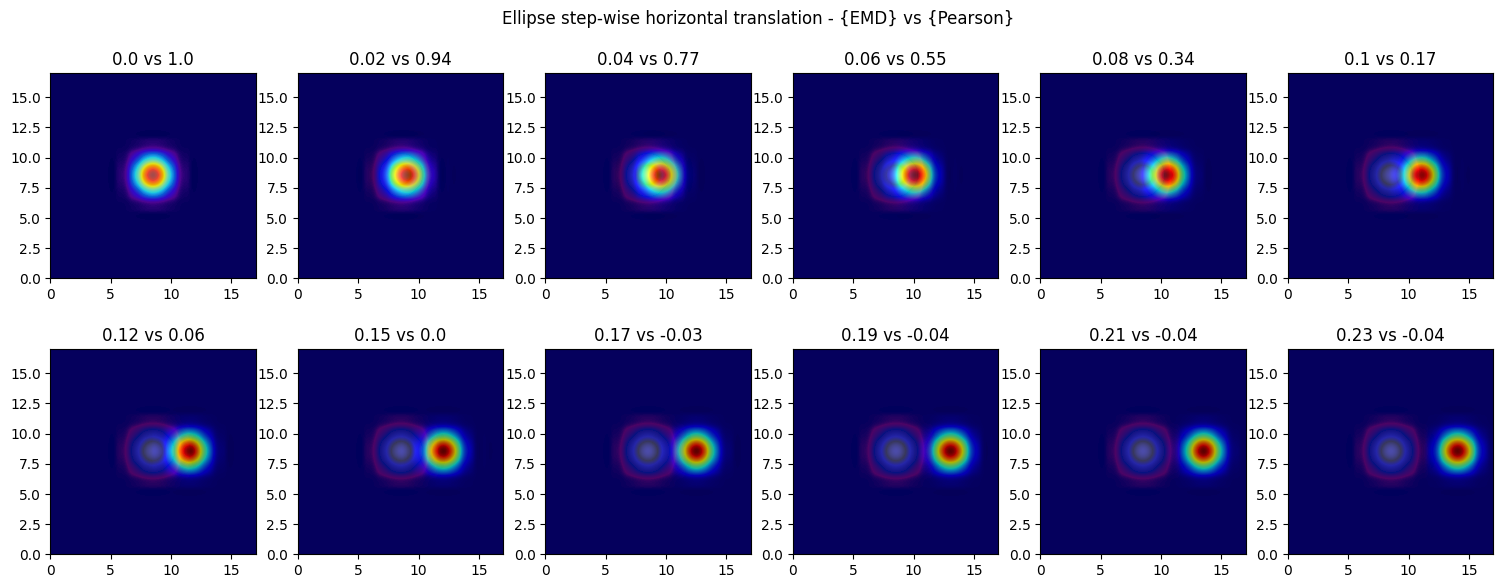

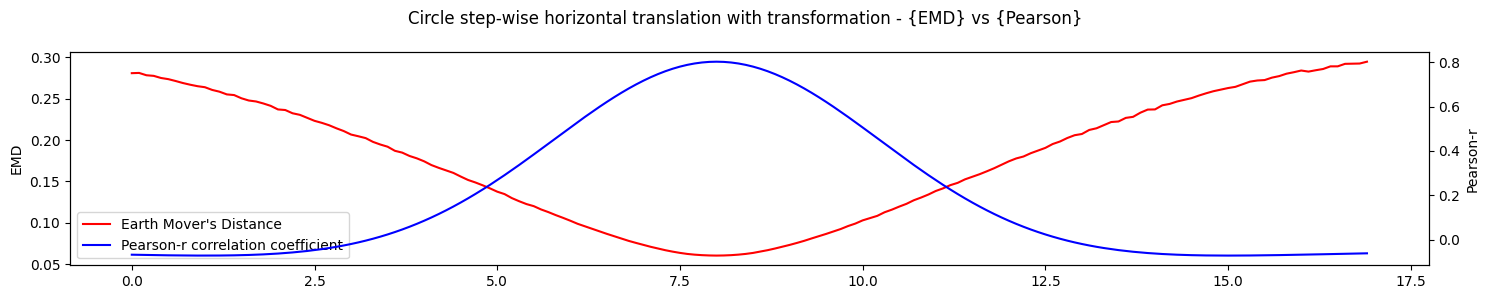

In [39]:
"""""""""""""""""""""" EXAMPLE 1 """""""""""""""""""""
""" No overlap same shape = circle_left_ex1 and circle_right_ex1 """

fig = plt.figure(figsize=(15,6))

c = 0
for circle_right_ex1 in aggregate_circle_right_ex1:

    ax = plt.subplot(2,6,c+1)
    ax.imshow(_interpolate_matrix(circle_right_ex1), cmap='jet', extent=[0,N-1,0,N-1])
    ax.imshow(_interpolate_matrix(circle_left_ex1), cmap='gist_stern', alpha=0.3, extent=[0,N-1,0,N-1])

    y, x = circle_left_ex1.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: circle_left_ex1[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: circle_right_ex1[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    # emd = pot.wass
    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())

    ax.set_title(str(round(emd, 2)) + ' vs ' + str(round(r, 2)))

    c += 1

fig.suptitle('Ellipse step-wise horizontal translation - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,3))
emds = []
pearsons = []
rx, ry = 2, 2
rot = 90
ctr_col = []

for i in np.arange(-int(N/2),ceil(N/2),0.1):
    # fld = make_single_field(N, stdev, shift_row=-ceil(N/2)+i, shift_col=0 ,custom_gauss=aggregate_elliptic_right_ex1[0])
    # fld = fld[N:N+N,N:N+N]

    sx, sy = int(N/2), int(N/2) + i
    circle_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 


    y, x = circle_left_ex1.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: circle_left_ex1[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: circle_right_ex1[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())

    ctr_col.append(ceil(N/2) + i - 1)
    emds.append(emd)
    pearsons.append(r)

ax  = plt.subplot(1,1,1)
ln1 = ax.plot(ctr_col, emds,label="Earth Mover's Distance",color='r')
axt = ax.twinx()
ln2 = axt.plot(ctr_col, pearsons, label='Pearson-r correlation coefficient',color='b')
ax.set_ylabel('EMD')
axt.set_ylabel('Pearson-r')
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
fig.suptitle('Circle step-wise horizontal translation with transformation - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()


In [40]:


"""""""""""""""""""""" EXAMPLE 3 - POPULATION FIGURES """""""""""""""""""""
""" Overlap same shape = circle_left_ex1 and circle_right_ex1 """

y, x = circle_left_ex1.shape
height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
source_weights = np.array(list(map(lambda x: circle_left_ex1[x[0],x[1]], buckets)))
source_weights = source_weights / np.sum(source_weights)
coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
pop_shifted_emd = np.zeros(circle_left_ex1.shape)
pop_shifted_pearson = np.zeros(circle_left_ex1.shape)


rx, ry = 1, 1

def _sub1(i, j):
    sx, sy = i, j
    rot = 90
    circle_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 

    target_weights = np.array(list(map(lambda y: circle_right_ex1[y[0],y[1]], buckets)))
    target_weights = target_weights / np.sum(target_weights)
            
    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)

    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())

    return emd, r

def _sub2(i):
    emd_and_r = np.array(list(map(lambda x: _sub1(i, x), np.arange(0,len(pop_shifted_emd)))))
    return emd_and_r[:,0], emd_and_r[:,1]

combined = np.array(list(map(lambda x: _sub2(x), np.arange(0,len(pop_shifted_emd)))))
pop_shifted_emd, pop_shifted_pearson = combined[:,0,:], combined[:,1,:]


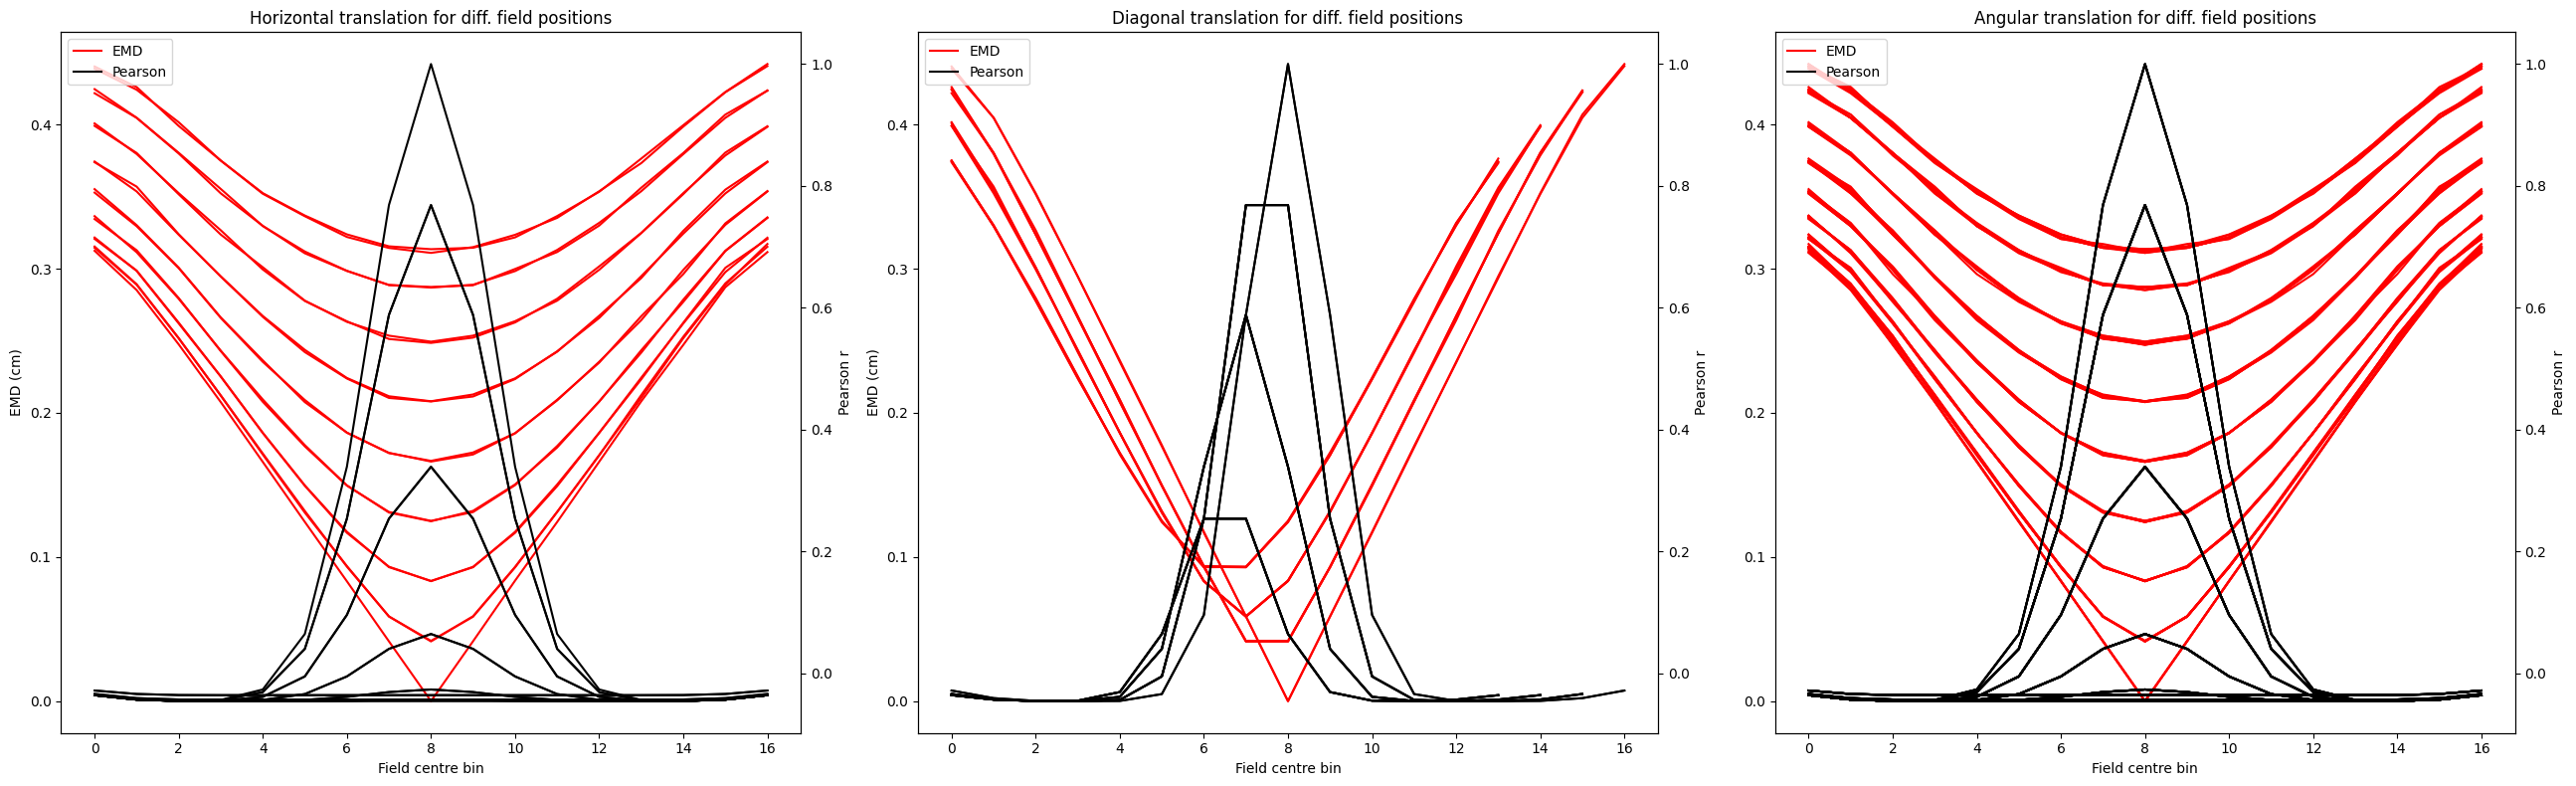

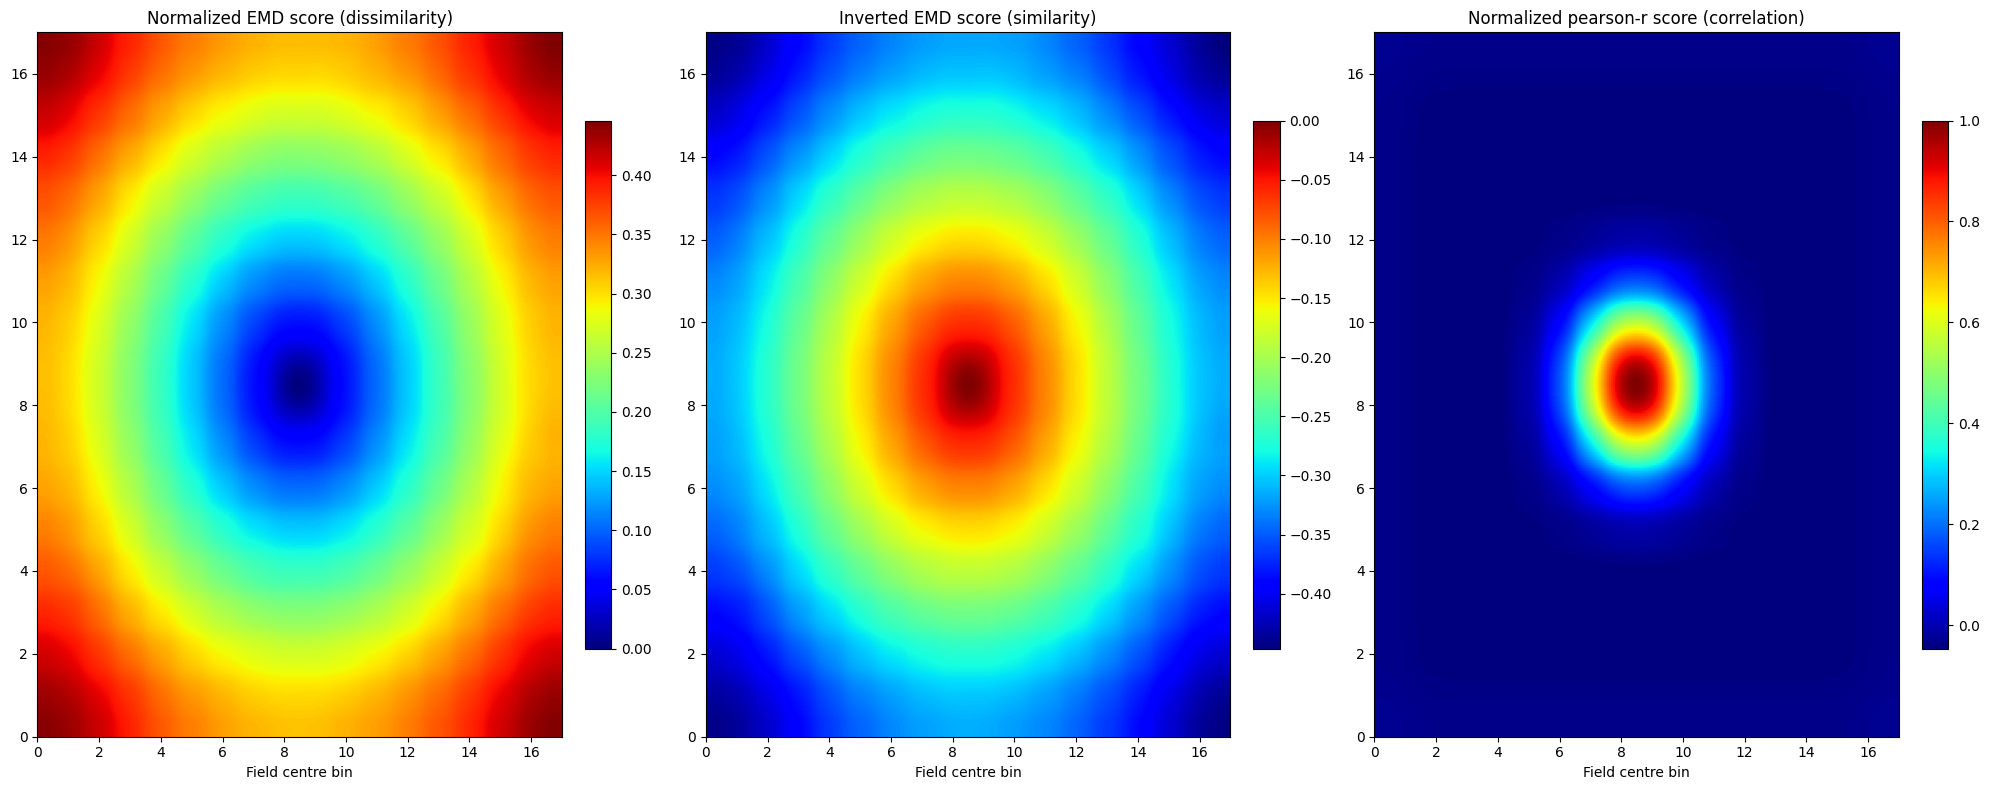

In [41]:
fig, _ = plt.subplots(1, 3, figsize=(26, 8))
ax1 = plt.subplot(1,3,1)
for i in range(N):
    p1 = ax1.plot(pop_shifted_emd[i],color='r',label='EMD')
ax1.set_xlabel('Field centre bin')
ax1.set_ylabel('EMD (cm)')
axtwin = ax1.twinx()
axtwin.set_ylabel('Pearson r')
for i in range(N):
    ptwin = axtwin.plot(pop_shifted_pearson[i],color='k',label='Pearson')
lns = p1+ptwin
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')
# ax1.set_aspect('equal')
ax1.set_title('Horizontal translation for diff. field positions')

def diag_matrix(matrix):
    diags = [matrix[::-1,:].diagonal(i) for i in range(-3,4)]
    diags.extend(matrix.diagonal(i) for i in range(3,-4,-1))
    return [n.tolist() for n in diags]

ax2 = plt.subplot(1,3,2)

diag_emd = diag_matrix(pop_shifted_emd)
for i in range(len(diag_emd)):
    p2 = ax2.plot(diag_emd[i],color='r',label='EMD')
ax2.set_xlabel('Field centre bin')
ax2.set_ylabel('EMD (cm)')
axtwin2 = ax2.twinx()
axtwin2.set_ylabel('Pearson r')

diag_pearson = diag_matrix(pop_shifted_pearson)
for i in range(len(diag_pearson)):
    ptwin2 = axtwin2.plot(diag_pearson[i],color='k',label='Pearson')
lns = p2+ptwin2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper left')
ax2.set_title('Diagonal translation for diff. field positions')

ax3 = plt.subplot(1,3,3)
rotated_emd = np.array(list(map(lambda x: ndimage.rotate(pop_shifted_emd, x, reshape=False, mode='constant', cval=np.nan), np.arange(0,360,90))))
pdct_emd = list(itertools.product(np.arange(len(rotated_emd)), np.arange(len(rotated_emd[0]))))
list(map(lambda x: ax3.plot(rotated_emd[x[0],x[1]],color='r',label='EMD'), pdct_emd))
p3 = ax3.plot(rotated_emd[0,0],color='r',label='EMD')
axtwin3 = ax3.twinx()
axtwin3.set_ylabel('Pearson r')
rotated_pearson = np.array(list(map(lambda x: ndimage.rotate(pop_shifted_pearson, x, reshape=False, mode='constant', cval=np.nan), np.arange(0,360,90))))
pdct_pearson = list(itertools.product(np.arange(len(rotated_pearson)), np.arange(len(rotated_pearson[0]))))
list(map(lambda x: axtwin3.plot(rotated_pearson[x[0],x[1]],color='k',label='EMD'), pdct_pearson))
ptwin3 = axtwin3.plot(rotated_pearson[0,0],color='k',label='Pearson')
lns = p3+ptwin3
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc='upper left')
ax3.set_title('Angular translation for diff. field positions')
ax3.set_xlabel('Field centre bin')

fig.tight_layout()
plt.show()

fig, _ = plt.subplots(1, 2, figsize=(20, 8))

ax4 = plt.subplot(1,3,1)
im = ax4.imshow(_interpolate_matrix(pop_shifted_emd), cmap='jet', aspect='equal', extent=[0,N-1,0,N-1])
ax4.set_title('EMD score (dissimilarity)')
ax4.set_xlabel('Field centre bin')
fig.colorbar(im, ax=ax4,fraction=0.046, pad=0.04)

ax5 = plt.subplot(1,3,2)
im = ax5.imshow(_interpolate_matrix(-pop_shifted_emd), cmap='jet', aspect='equal', extent=[0,N-1,0,N-1])
ax5.set_title('Inverted EMD score (similarity)')
ax5.set_xlabel('Field centre bin')
fig.colorbar(im, ax=ax5,fraction=0.046, pad=0.04)

ax6 = plt.subplot(1,3,3)
ax6.set_xlabel('Field centre bin')
im = ax6.imshow(_interpolate_matrix(pop_shifted_pearson), cmap='jet', aspect='equal', extent=[0,N-1,0,N-1])
ax6.set_title('Pearson-r score (correlation)')
fig.colorbar(im, ax=ax6,fraction=0.046, pad=0.04)

fig.tight_layout()
plt.show()

In [18]:
N = 33
axs = []
scaling_fields = {}
aggregate_circle_scaling = []

for i in range(1,13,1):
    stdev = i/2
    single_field = make_single_field(N, stdev)
    field = single_field[N:N+N,N:N+N]

    aggregate_circle_scaling.append(field)

circle_right_stable = aggregate_circle_scaling[0]

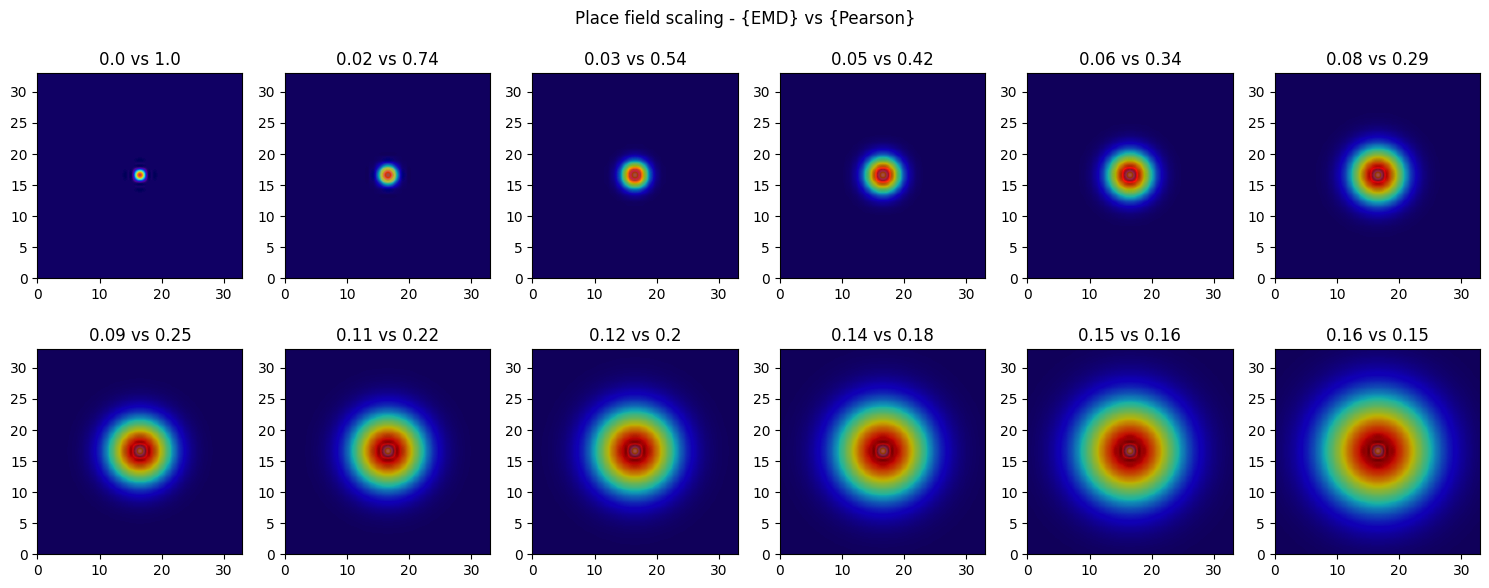

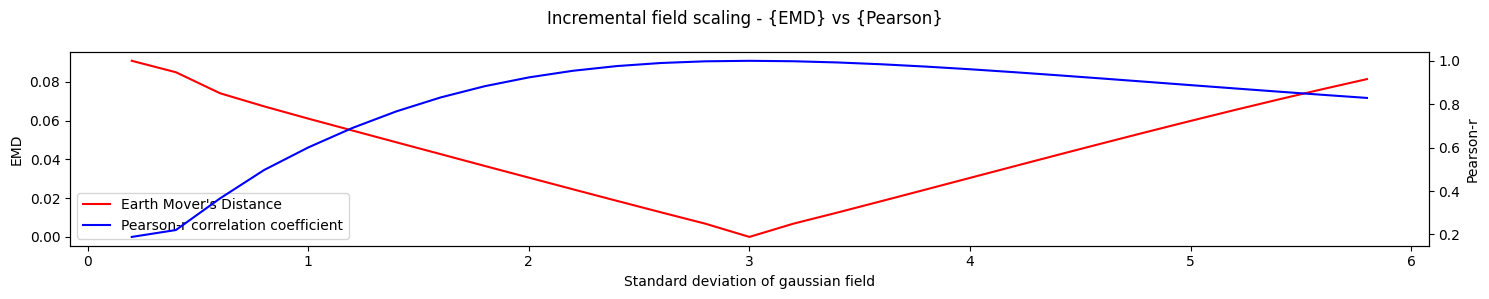

In [19]:
"""""""""""""""""""""" EXAMPLE 1 """""""""""""""""""""
""" No overlap same shape = elliptic_left_ex1 and elliptic_right_ex1 """

fig = plt.figure(figsize=(15,6))

c = 0
for circle_right_scaling in aggregate_circle_scaling:

    ax = plt.subplot(2,6,c+1)
    ax.imshow(_interpolate_matrix(circle_right_scaling), cmap='jet', extent=[0,N-1,0,N-1])
    ax.imshow(_interpolate_matrix(circle_right_stable), cmap='gist_stern', alpha=0.3, extent=[0,N-1,0,N-1])
    
    y, x = circle_right_stable.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: circle_right_stable[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: circle_right_scaling[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    # emd = pot.wass
    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())

    ax.set_title(str(round(emd, 2)) + ' vs ' + str(round(r, 2)))

    c += 1

fig.suptitle('Place field scaling - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,3))
emds = []
pearsons = []
ctr_col = []
single_field = make_single_field(N, 3)
circle_right_stable = single_field[N:N+N,N:N+N]

for i in np.arange(0.2,6,0.2):
    # fld = make_single_field(N, stdev, shift_row=-ceil(N/2)+i, shift_col=0 ,custom_gauss=aggregate_elliptic_right_ex1[0])
    # fld = fld[N:N+N,N:N+N]

    stdev = i
    single_field = make_single_field(N, stdev)
    circle_right_scaling = single_field[N:N+N,N:N+N]
    

    y, x = circle_right_stable.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: circle_right_stable[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: circle_right_scaling[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())

    ctr_col.append(stdev)
    emds.append(emd)
    pearsons.append(r)

ax  = plt.subplot(1,1,1)
ln1 = ax.plot(ctr_col, emds,label="Earth Mover's Distance",color='r')
axt = ax.twinx()
ln2 = axt.plot(ctr_col, pearsons, label='Pearson-r correlation coefficient',color='b')
ax.set_ylabel('EMD')
axt.set_ylabel('Pearson-r')
ax.set_xlabel('Standard deviation of gaussian field')
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
fig.suptitle('Incremental field scaling - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()


In [20]:
N = 33
axs = []
aggregate_circle_rotating = []
rot = 0
step = 30
stdev = 3
row_shift = -7

for i in range(0,12,1):
    single_field = make_single_field(N, stdev, shift_row=row_shift)
    single_field = ndimage.rotate(single_field, rot + i*step, reshape=False, mode='constant', cval=np.nan)
    field = single_field[N:N+N,N:N+N]

    aggregate_circle_rotating.append(field)

circle_right_stable = aggregate_circle_rotating[0]

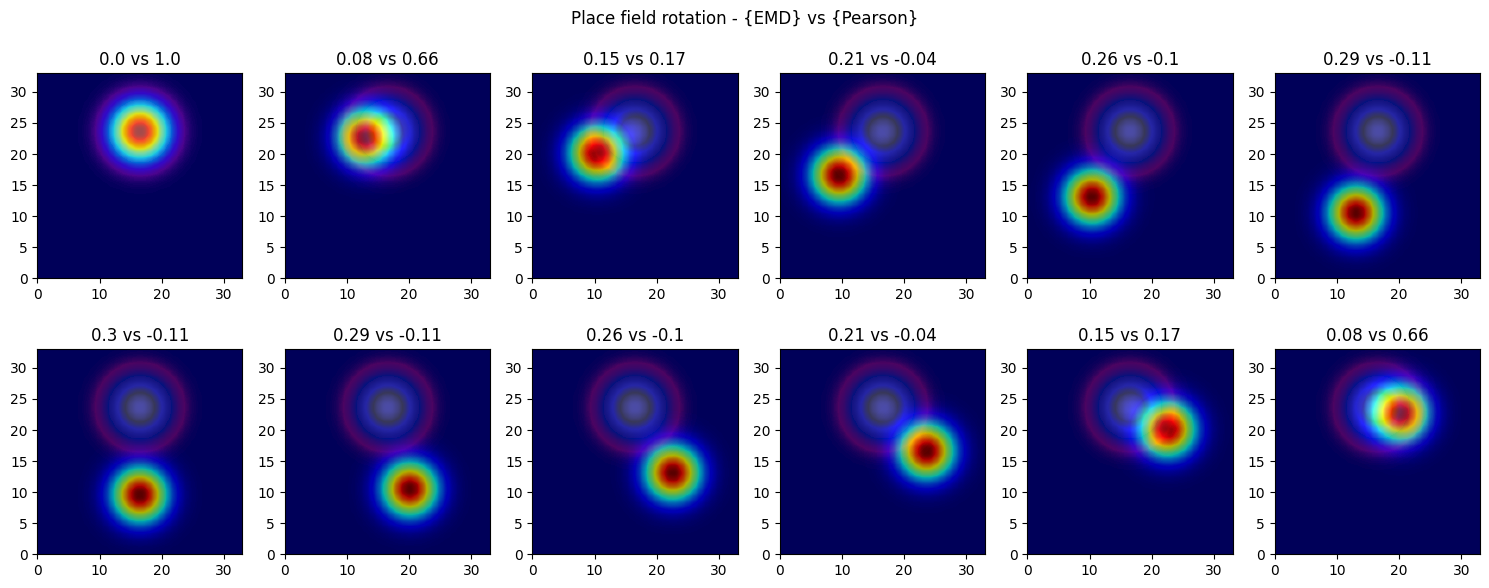

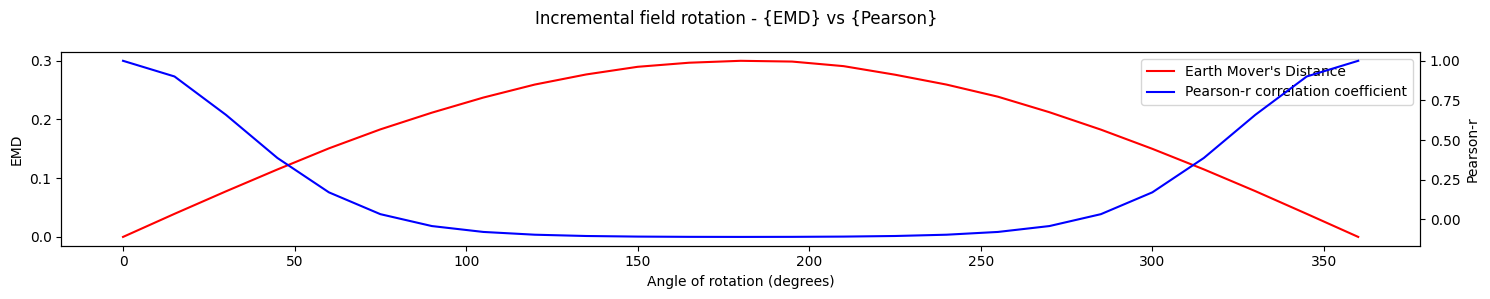

In [21]:
"""""""""""""""""""""" EXAMPLE """""""""""""""""""""
"""""""""""""""" Rotating place field """""""""""""""

fig = plt.figure(figsize=(15,6))

c = 0
for circle_right_rotating in aggregate_circle_rotating:

    ax = plt.subplot(2,6,c+1)
    ax.imshow(_interpolate_matrix(circle_right_rotating), cmap='jet', extent=[0,N-1,0,N-1])
    ax.imshow(_interpolate_matrix(circle_right_stable), cmap='gist_stern', alpha=0.3, extent=[0,N-1,0,N-1])

    y, x = circle_right_stable.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: circle_right_stable[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: circle_right_rotating[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    # emd = pot.wass
    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())

    ax.set_title(str(round(emd, 2)) + ' vs ' + str(round(r, 2)))

    c += 1

fig.suptitle('Place field rotation - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,3))
emds = []
pearsons = []
ctr_col = []

rot = 0
step = 15
row_shift = -7

single_field = make_single_field(N, stdev, shift_row=row_shift)
circle_right_stable = single_field[N:N+N,N:N+N]

for i in np.arange(0, 360+step, step):

    single_field = make_single_field(N, stdev, shift_row=row_shift)
    single_field = ndimage.rotate(single_field, rot + i, reshape=False, mode='constant', cval=np.nan)
    circle_right_rotating = single_field[N:N+N,N:N+N]
    

    y, x = circle_right_stable.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: circle_right_stable[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: circle_right_rotating[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**4)
    r, p = pearsonr(source_weights.flatten(), target_weights.flatten())

    ctr_col.append(rot + i)
    emds.append(emd)
    pearsons.append(r)

ax  = plt.subplot(1,1,1)
ln1 = ax.plot(ctr_col, emds,label="Earth Mover's Distance",color='r')
axt = ax.twinx()
ln2 = axt.plot(ctr_col, pearsons, label='Pearson-r correlation coefficient',color='b')
ax.set_ylabel('EMD')
axt.set_ylabel('Pearson-r')
ax.set_xlabel('Angle of rotation (degrees)')
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
fig.suptitle('Incremental field rotation - {EMD} vs {Pearson}')
fig.tight_layout()
plt.show()


In [590]:
N = 17
rx, ry = 1, 1
sx, sy = int(N/2), int(N/2)
rot = 90
circle_left_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 

rx, ry = 1, 1
rot = 0
aggregate_circle_right_ex1 = []
step = 0.5
for i in range(12):
    sx, sy = int(N/2) + i * 0.5, int(N/2)
    circle_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 
    aggregate_circle_right_ex1.append(circle_right_ex1)

agg_pop_shifted_emd = []
# projection_count = [0,1,2,3,4]
# proj_counts = [1,2,5,7,10,25,50,75,100,250,500,750,1000,2500,5000,7500,10000]
proj_counts = np.arange(0,51,1)
proj_counts = np.hstack((proj_counts, [75,100,250,500,750,1000,2500,5000,7500,10000]))

for n_proj in proj_counts:
    print(n_proj)

    """""""""""""""""""""" EXAMPLE 3 - POPULATION FIGURES """""""""""""""""""""
    """ Overlap same shape = circle_left_ex1 and circle_right_ex1 """

    y, x = circle_left_ex1.shape
    height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: circle_left_ex1[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
    pop_shifted_emd = np.zeros(circle_left_ex1.shape)
    pop_shifted_pearson = np.zeros(circle_left_ex1.shape)


    rx, ry = 1, 1

    def _sub1(i, j):
        sx, sy = i, j
        rot = 90
        circle_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 

        target_weights = np.array(list(map(lambda y: circle_right_ex1[y[0],y[1]], buckets)))
        target_weights = target_weights / np.sum(target_weights)
                
        # emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=10**n_proj)
        
        emd = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=n_proj)

        r, p = pearsonr(source_weights.flatten(), target_weights.flatten())

        return emd, r

    def _sub2(i):
        emd_and_r = np.array(list(map(lambda x: _sub1(i, x), np.arange(0,len(pop_shifted_emd)))))
        return emd_and_r[:,0], emd_and_r[:,1]

    combined = np.array(list(map(lambda x: _sub2(x), np.arange(0,len(pop_shifted_emd)))))
    pop_shifted_emd, pop_shifted_pearson = combined[:,0,:], combined[:,1,:]

    agg_pop_shifted_emd.append(pop_shifted_emd)


0
1


c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\_prototypes\cell_remapping\src\wasserstein_distance.py:435: RuntimeWarning: invalid value encountered in double_scalars
  res = (nx.sum(projected_emd) / n_projections) ** (1.0 / p)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [595]:
to_stack[7:].shape

(10, 17, 17)

In [599]:
agg_pop_shifted_emd = np.vstack((np.array(agg_pop_shifted_emd), to_stack[7:]))
print(agg_pop_shifted_emd.shape)

(61, 17, 17)


In [608]:
agg_pop_shifted_emd.shape

(61, 17, 17)

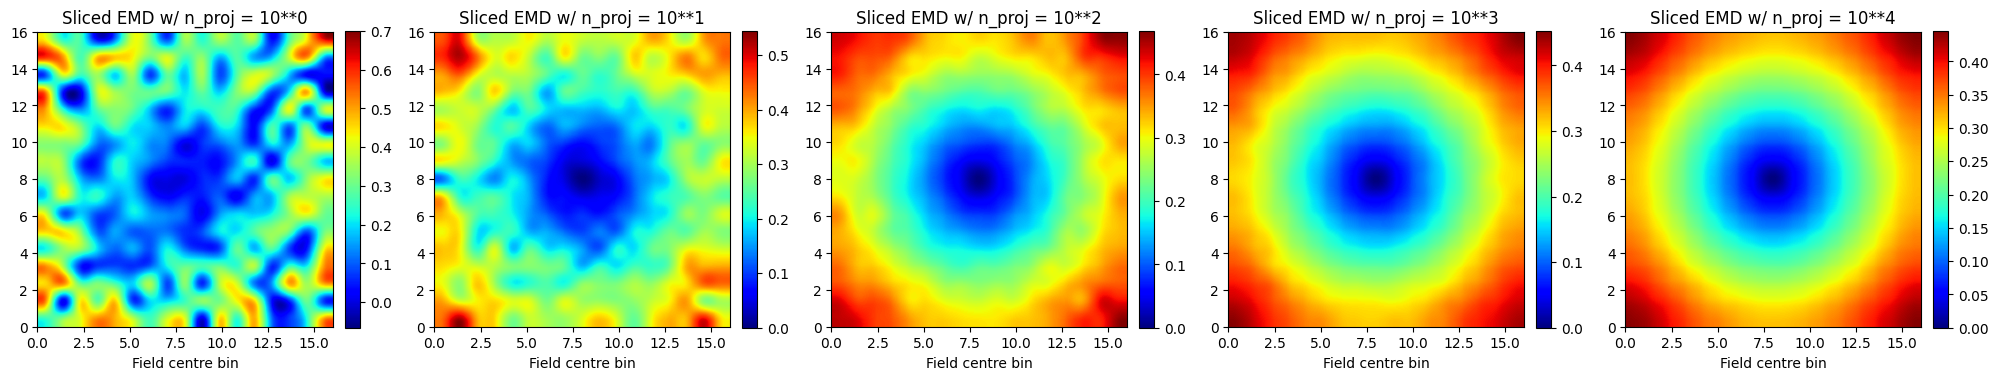

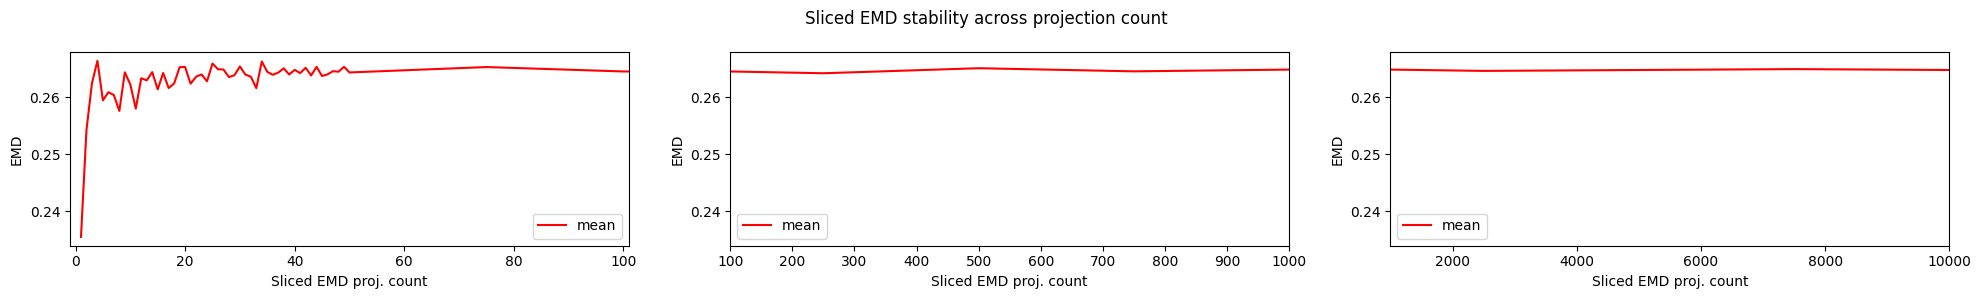

In [611]:
fig, _ = plt.subplots(1, 2, figsize=(20, 8))

# proj_counts = np.array([1,2,5,7,10,25,50,75,100,250,500,750,1000,2500,5000,7500,10000])
proj_counts = np.arange(0,51,1)
proj_counts = np.hstack((proj_counts, [75,100,250,500,750,1000,2500,5000,7500,10000]))
first_plot = np.array([1,10,100,1000,10000])
projection_count = [0,1,2,3,4]

for i in range(len(first_plot)):

    idx = np.where(proj_counts == first_plot[i])[0][0]

    ax4 = plt.subplot(1,len(first_plot),i+1)
    im = ax4.imshow(_interpolate_matrix(agg_pop_shifted_emd[idx]), cmap='jet', aspect='equal', extent=[0,N-1,0,N-1])
    ax4.set_title('Sliced EMD w/ n_proj = 10**' + str(projection_count[i]))
    ax4.set_xlabel('Field centre bin')
    fig.colorbar(im, ax=ax4,fraction=0.046, pad=0.04)


fig.tight_layout()
plt.show()

avgs = list(map(lambda x: np.mean(agg_pop_shifted_emd[x]), np.arange(len(agg_pop_shifted_emd))))
# upper = list(map(lambda x: np.mean(agg_pop_shifted_emd[x]) + 2 * np.std(agg_pop_shifted_emd[x]), np.arange(len(agg_pop_shifted_emd))))
# lower = list(map(lambda x: np.mean(agg_pop_shifted_emd[x]) - 2 * np.std(agg_pop_shifted_emd[x]), np.arange(len(agg_pop_shifted_emd))))


fig = plt.figure(figsize=(20,3))

ax = plt.subplot(1,3,1)
ax.plot(proj_counts, avgs, color='r', label='mean')
ax.set_xlabel('Sliced EMD proj. count')
ax.set_ylabel('EMD')
ax.set_xlim(-1,101)
ax.legend()

ax = plt.subplot(1,3,2)
ax.plot(proj_counts, avgs, color='r', label='mean')
ax.set_xlabel('Sliced EMD proj. count')
ax.set_ylabel('EMD')
ax.set_xlim(100,1000)
ax.legend()

ax = plt.subplot(1,3,3)
ax.plot(proj_counts, avgs, color='r', label='mean')
ax.set_xlabel('Sliced EMD proj. count')
ax.set_ylabel('EMD')
ax.set_xlim(1000,10001)
ax.legend()

fig.suptitle('Sliced EMD stability across projection count')

fig.tight_layout()
plt.show()

In [581]:
stds

[0.14092063285559978,
 0.1229830136669936,
 0.0990991904621202,
 0.10625284337548356,
 0.10353258681064899,
 0.09680235323906425,
 0.09725542183649381,
 0.09516035109866067,
 0.0960671048342085,
 0.09463523768643697,
 0.09532547143295927,
 0.09452911838151093,
 0.09490965733588963,
 0.09470944360598116,
 0.09488159529588444,
 0.09497365488595967,
 0.09488683365262764]

In [616]:
stdev = 3
N = 17
n_proj = 3

left_middle = make_single_field(N, stdev, shift_row=0, shift_col=-ceil(N/2)+ceil(N/4))[N:N+N,N:N+N]
right_middle = make_single_field(N, stdev, shift_row=0, shift_col=ceil(N/2)-ceil(N/4))[N:N+N,N:N+N]
# bottom_right = make_single_field(N, stdev, shift_row=ceil(N/2)-ceil(N/4), shift_col=ceil(N/2)-ceil(N/4))[N:N+N,N:N+N]
top_middle = make_single_field(N, stdev, shift_row=-ceil(N/2), shift_col=0)[N:N+N,N:N+N]
center = make_single_field(N, stdev)[N:N+N,N:N+N]
bottom_right = make_single_field(N, stdev, shift_row=ceil(N/2), shift_col=ceil(N/2))[N:N+N,N:N+N]
bottom_left = make_single_field(N, stdev, shift_row=ceil(N/2)-ceil(N/4), shift_col=-ceil(N/2)+ceil(N/4))[N:N+N,N:N+N]
noises = []

to_plot = [top_middle, center, bottom_right, bottom_left]
noise_stdev = [0,0.1,0.5]
# c = 0

for c in range(len(to_plot)):
    fig = plt.figure(figsize=(12,12))
    n_count = 0
    for i in [1,5,9]:
        noise = np.random.normal(0,noise_stdev[n_count],(N,N))

        source_field = to_plot[c] + noise

        ax = plt.subplot(4,4,i)

        im = ax.imshow(_interpolate_matrix(source_field), extent=[0,N-1,0,N-1], cmap='jet', aspect='equal')
        fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
        ax.set_title('Field stdev: ' + str(noise_stdev[n_count]))

        ax = plt.subplot(4,4,i+1)

        noises.append(noise)

        y, x = source_field.shape
        height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
        buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
        source_weights = np.array(list(map(lambda x: source_field[x[0],x[1]], buckets)))
        source_weights = source_weights / np.sum(source_weights)
        source_coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
        pop_shifted_emd = np.zeros(source_field.shape)
        pop_shifted_pearson = np.zeros(source_field.shape)

        def _sub1(i, j):

            row_inds = np.arange(0,17,1)
            col_inds = np.arange(0,17,1)

            # field = make_single_field(N, stdev, shift_row=row_inds[i],shift_col=col_inds[j])[N:N+N,N:N+N]
            # fld_copy = np.copy(field)
            # fld_copy[:i,:j] = np.nan
            field = np.zeros(source_field.shape)
            field[i,j] = 1

            target_weights = np.array(list(map(lambda y: field[y[0],y[1]], buckets)))
            # if np.isnan(target_weights).any() == True:
            #     print('here')

            # nan_ids = np.where(np.isnan(target_weights))[0]
            # no_nan_ids = np.where(~np.isnan(target_weights))[0]
            # target_weights = target_weights[no_nan_ids]
                
            target_weights = target_weights / np.sum(target_weights)
            target_coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
            # target_coord_buckets = target_coord_buckets[no_nan_ids]
                
            # print('here')
            emd = pot_sliced_wasserstein(source_coord_buckets, target_coord_buckets, source_weights, target_weights, n_projections=10**n_proj)
                
            try:
                r, p = pearsonr(source_weights.flatten(), target_weights.flatten())
            except:
                r = np.nan
            return emd, r

        def _sub2(i):
            emd_and_r = np.array(list(map(lambda x: _sub1(i, x), np.arange(0,len(pop_shifted_emd)))))
            return emd_and_r[:,0], emd_and_r[:,1]


        combined = np.array(list(map(lambda x: _sub2(x), np.arange(0,len(pop_shifted_emd)))))
        pop_shifted_emd, pop_shifted_pearson = combined[:,0,:], combined[:,1,:]

        im = ax.imshow(_interpolate_matrix(pop_shifted_emd), cmap='jet', extent=[0,N-1,0,N-1])
        ax.set_title('EMD scores')
        ax.set_xlabel('Field centre bin')
        fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)

        ax = plt.subplot(4,4,i+2)

        im = ax.imshow(_interpolate_matrix(pop_shifted_pearson), cmap='jet', extent=[0,N-1,0,N-1])
        ax.set_title('Pearson scores')
        ax.set_xlabel('Field centre bin')
        fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)

        ax = plt.subplot(4,4,i+3)

        z_score = 1.282 # 90th percentile
        # z_score = 0.842 # 80th percentile

        scatter_copy = np.zeros(pop_shifted_emd.shape)
        row, col = np.where(pop_shifted_emd <= np.mean(pop_shifted_emd) - z_score*np.std(pop_shifted_emd))
        scatter_copy[row, col] = 1
        imB = ax.imshow(scatter_copy,cmap='Greys',alpha=1,label='EMD', extent=[0,N-1,0,N-1])

        scatter_copy = np.zeros(pop_shifted_pearson.shape)
        row, col = np.where(pop_shifted_pearson >= np.mean(pop_shifted_pearson) + z_score*np.std(pop_shifted_pearson))
        scatter_copy[row, col] = 1
        im = ax.imshow(scatter_copy, cmap='Greys',alpha=0.5,label='Pearson-r', extent=[0,N-1,0,N-1])

        ax.set_title('90th percentile blobs')
        ax.set_xlabel('EMD - black, Pearson - grey')
        # cb = fig.colorbar(imB, ax=ax,fraction=0.046, pad=0.04)
        # cb.remove()

        n_count += 1

    fig.tight_layout()
    plt.show()


In [556]:
plt.close()

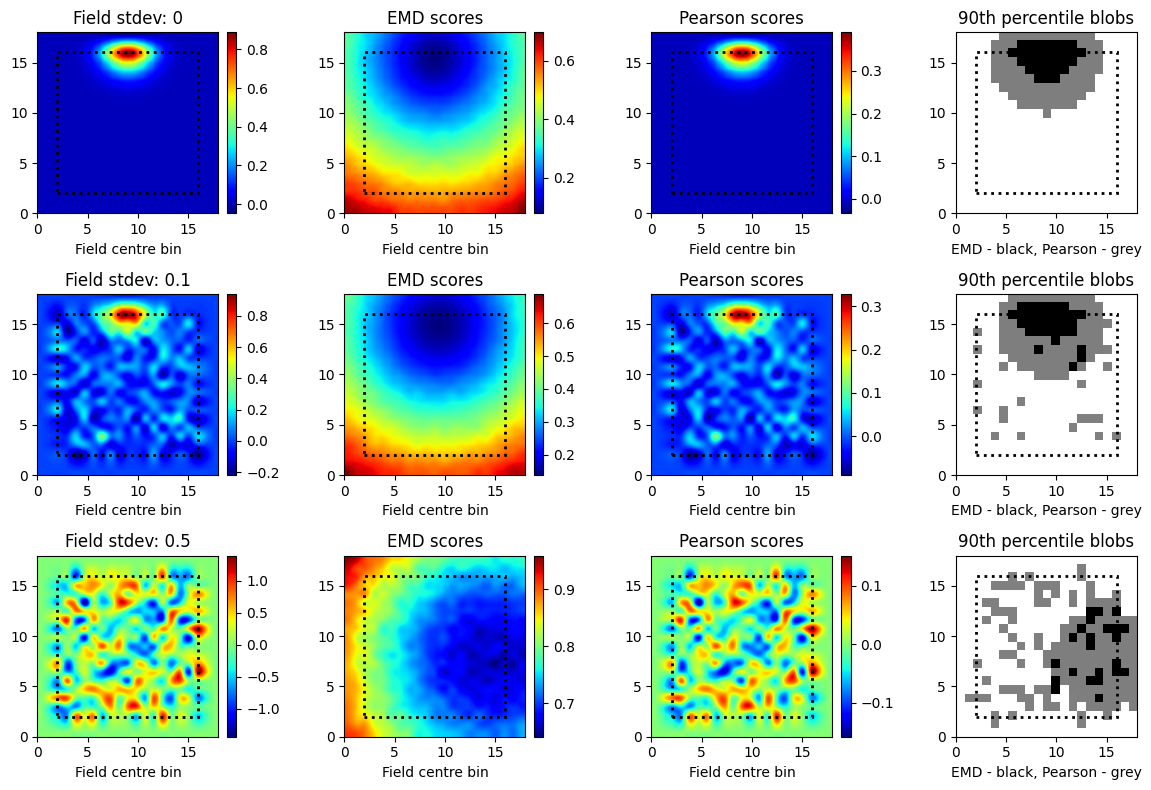

KeyboardInterrupt: 

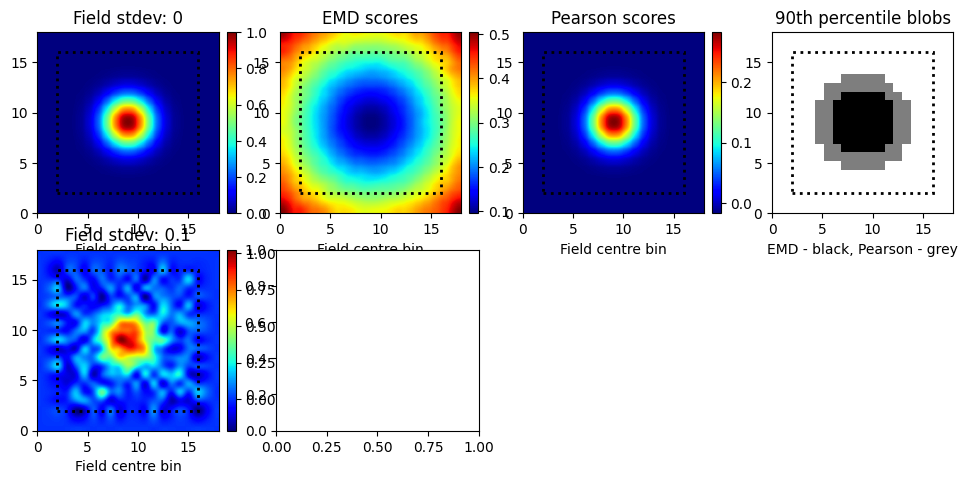

In [615]:
stdev = 3
N = 17
n_proj = 3
padN = 2


left_middle = make_single_field(N, stdev, shift_row=0, shift_col=-ceil(N/2)+ceil(N/4))[N:N+N,N:N+N]
right_middle = make_single_field(N, stdev, shift_row=0, shift_col=ceil(N/2)-ceil(N/4))[N:N+N,N:N+N]
# bottom_right = make_single_field(N, stdev, shift_row=ceil(N/2)-ceil(N/4), shift_col=ceil(N/2)-ceil(N/4))[N:N+N,N:N+N]
top_middle = make_single_field(N, stdev, shift_row=-ceil(N/2), shift_col=0)[N:N+N,N:N+N]
center = make_single_field(N, stdev)[N:N+N,N:N+N]
bottom_right = make_single_field(N, stdev, shift_row=int(N/2), shift_col=int(N/2))[N:N+N,N:N+N]
bottom_left = make_single_field(N, stdev, shift_row=ceil(N/2)-ceil(N/4), shift_col=-ceil(N/2)+ceil(N/4))[N:N+N,N:N+N]


to_plot = [top_middle, center, bottom_right, bottom_left]
# to_plot_labels = ['Top Middle (edge)', 'Center', 'Bottom Right (edge)', 'Bottom Left']

to_plot = [top_middle, center, bottom_right, bottom_left]

for c in range(len(to_plot)):
    fig = plt.figure(figsize=(12,8))
    n_count = 0
    for i in [1,5,9]:
        noise = noises[n_count]
        
        ax = plt.subplot(3,4,i)

        source_field = to_plot[c] + noise

        source_field = np.pad(source_field, (padN, padN), mode='linear_ramp')

        im = ax.imshow(_interpolate_matrix(source_field), extent=[0,N-1+padN,0,N-1+padN], cmap='jet', aspect='equal')
        # ax.set_title(to_plot_labels[c])
        ax.set_title('Field stdev: ' + str(noise_stdev[n_count]))
        fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
        rect = patches.Rectangle((padN,padN), N-1-padN, N-1-padN, linewidth=2, linestyle=':', edgecolor='k', facecolor='none')
        ax.add_patch(rect)
        ax.set_xlabel('Field centre bin')


        ax = plt.subplot(3,4,i+1)

        y, x = source_field.shape
        height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
        buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
        source_weights = np.array(list(map(lambda x: source_field[x[0],x[1]], buckets)))
        source_weights = source_weights / np.sum(source_weights)
        source_coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
        pop_shifted_emd = np.zeros(source_field.shape)
        pop_shifted_pearson = np.zeros(source_field.shape)


        def _sub1(i, j):

            row_inds = np.arange(0,17,1)
            col_inds = np.arange(0,17,1)

            # field = make_single_field(N, stdev, shift_row=row_inds[i],shift_col=col_inds[j])[N:N+N,N:N+N]
            # fld_copy = np.copy(field)
            # fld_copy[:i,:j] = np.nan
            field = np.zeros(source_field.shape)
            field[i,j] = 1

            target_weights = np.array(list(map(lambda y: field[y[0],y[1]], buckets)))
            # if np.isnan(target_weights).any() == True:
            #     print('here')

            # nan_ids = np.where(np.isnan(target_weights))[0]
            # no_nan_ids = np.where(~np.isnan(target_weights))[0]
            # target_weights = target_weights[no_nan_ids]
            
            target_weights = target_weights / np.sum(target_weights)
            target_coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
            # target_coord_buckets = target_coord_buckets[no_nan_ids]
            
            # print('here')
            emd = pot_sliced_wasserstein(source_coord_buckets, target_coord_buckets, source_weights, target_weights, n_projections=10**n_proj)
            
            # try:
            r, p = pearsonr(source_weights.flatten(), target_weights.flatten())
            # except:
            #     r = np.nan
            return emd, r

        def _sub2(i):
            emd_and_r = np.array(list(map(lambda x: _sub1(i, x), np.arange(0,len(pop_shifted_emd)))))
            return emd_and_r[:,0], emd_and_r[:,1]


        combined = np.array(list(map(lambda x: _sub2(x), np.arange(0,len(pop_shifted_emd)))))
        pop_shifted_emd, pop_shifted_pearson = combined[:,0,:], combined[:,1,:]

        im = ax.imshow(_interpolate_matrix(pop_shifted_emd), cmap='jet', extent=[0,N-1+padN,0,N-1+padN])
        ax.set_title('EMD scores')
        ax.set_xlabel('Field centre bin')
        fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
        rect = patches.Rectangle((padN,padN), N-1-padN, N-1-padN, linewidth=2, linestyle=':', edgecolor='k', facecolor='none')
        ax.add_patch(rect)

        ax = plt.subplot(3,4,i+2)

        im = ax.imshow(_interpolate_matrix(pop_shifted_pearson), cmap='jet', extent=[0,N-1+padN,0,N-1+padN])
        # extent=[0,N-1+padN,0,N-1+padN])
        ax.set_title('Pearson scores')
        ax.set_xlabel('Field centre bin')
        fig.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
        # rect = patches.Rectangle((int(257/N)*padN, int(257/N)*padN), 5, 5, linewidth=1, edgecolor='r', facecolor='none')
        rect = patches.Rectangle((padN,padN), N-1-padN, N-1-padN, linewidth=2, linestyle=':', edgecolor='k', facecolor='none')
        ax.add_patch(rect)

        ax = plt.subplot(3,4,i+3)

        # z_score = 1.282 # 90th percentile
        z_score = 0.842 # 80th percentile

        scatter_copy = np.zeros(pop_shifted_emd.shape)
        row, col = np.where(pop_shifted_emd <= np.mean(pop_shifted_emd) - z_score*np.std(pop_shifted_emd))
        scatter_copy[row, col] = 1
        imB = ax.imshow(scatter_copy,cmap='Greys',alpha=1,label='EMD', extent=[0,N-1+padN,0,N-1+padN])

        scatter_copy = np.zeros(pop_shifted_pearson.shape)
        row, col = np.where(pop_shifted_pearson >= np.mean(pop_shifted_pearson) + z_score*np.std(pop_shifted_pearson))
        scatter_copy[row, col] = 1
        im = ax.imshow(scatter_copy, cmap='Greys',alpha=0.5,label='Pearson-r', extent=[0,N-1+padN,0,N-1+padN])

        rect = patches.Rectangle((padN,padN), N-1-padN, N-1-padN, linewidth=2, linestyle=':', edgecolor='k', facecolor='none')
        ax.add_patch(rect)
        ax.set_title('90th percentile blobs')
        ax.set_xlabel('EMD - black, Pearson - grey')
        # cb = fig.colorbar(imB, ax=ax,fraction=0.046, pad=0.04)

        n_count += 1

    fig.tight_layout()
    plt.show()
